In [1]:
import os
import gc
import optuna
import warnings
import numpy as np
from utils import *
import pandas as pd
from copy import deepcopy
from feature_extraction import *
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from train_models import get_model_scores
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold
warnings.filterwarnings('ignore')

class config:
    train_path = '../../../datasets/garanti-bbva-data-camp/train_users.csv'
    test_path = '../../../datasets/garanti-bbva-data-camp/test_users.csv'
    sub_path = '../../../datasets/garanti-bbva-data-camp/submission.csv'
    skills_path = '../../../datasets/garanti-bbva-data-camp/clean_skills.csv'
    languages_path = '../../../datasets/garanti-bbva-data-camp/clean_language.csv'
    education_path = '../../../datasets/garanti-bbva-data-camp/clean_education.csv'
    exp_path = '../../../datasets/garanti-bbva-data-camp/work_experiences.csv'
    seed = 42
    n_folds = 8
    study_size = 55
    school_size = 50
    language_size = 8
    degree_size = 18
    skill_size = 120
    skill_exact_match = False
    degree_exact_match = True
    school_exact_match = True
    study_exact_match = False

In [2]:
train_df = pd.read_csv(config.train_path)
test_df = pd.read_csv(config.test_path)
sub = pd.read_csv(config.sub_path)

print(f'train_df shape: {train_df.shape}')
print(f'test_df shape: {test_df.shape}')
df = train_df.append(test_df).reset_index(drop = True)

df.head()

train_df shape: (53019, 4)
test_df shape: (13255, 3)


,user_id,industry,location,moved_after_2019
0,1301,Information Technology and Services,"Istanbul, Istanbul, Turkey",1.0
1,6950,Internet,"Istanbul, Istanbul, Turkey",0.0
2,4880,Online Media,Turkey,0.0
3,26046,Telecommunications,"Istanbul, Istanbul, Turkey",0.0
4,11005,Banking,"Istanbul, Turkey",0.0


In [3]:
def fix_location(dataframe: pd.DataFrame, feature: str = "location") -> pd.DataFrame:

    tr_cities = load_tr_cities()
    df_ = dataframe.copy()
    df_.loc[
        df_[feature].astype(str).str.contains("Kahraman Maras"), feature
    ] = "Kahramanmaras, Turkey"
    df_.loc[
        df_[feature].astype(str).str.contains("Şanliurfa"), feature
    ] = "Sanliurfa, Turkey"
    df_.loc[df_[feature].astype(str).str.contains("İçel"), feature] = "Mersin, Turkey"
    df_.loc[
        df_[feature].astype(str).str.contains("Afyon"), feature
    ] = "Afyonkarahisar, Turkey"
    df_[feature] = df_[feature].apply(lambda x: str(x).replace("Türkiye", "Turkey"))
    df_[feature] = df_[feature].apply(lambda x: x.upper().strip())
    df_[feature] = df_[feature].apply(lambda x: translation(str(x)))
    for city in tr_cities:
        df_[feature] = df_[feature].apply(lambda x: city if city in x else x)
    df_[f"{feature}_based_on_tr"] = df_[feature].apply(
        lambda x: 1 if x in tr_cities or x == "TURKEY" else 0
    )

    return df_


skills_df = load_skills(
    config.skills_path, config.skill_size, exact_match=config.skill_exact_match
)
school_df = load_school(
    config.education_path, config.school_size, exact_match=config.school_exact_match
)
degree_df = load_degree(
    config.education_path, config.degree_size, exact_match=config.degree_exact_match
)
study_df = load_study(
    config.education_path, config.study_size, exact_match=config.study_exact_match
)
lang_df = load_languages(config.languages_path, config.language_size)
exp_df = load_work_experiences(config.exp_path)

df = fix_location(df)
df = df.merge(skills_df, on=["user_id"], how="left")
df = df.merge(lang_df, on=["user_id"], how="left")
df = df.merge(school_df, on=["user_id"], how="left")
df = df.merge(degree_df, on=["user_id"], how="left")
df = df.merge(study_df, on=["user_id"], how="left")
df = df.merge(exp_df, on=["user_id"], how="left")
df = add_populations(df)
# df = add_employment(df)

df["nunique_company_by_industries"] = df.groupby(by="industry")["company_id"].transform(
    "nunique"
)
df["active_employees_by_companies"] = df.groupby(by="company_id")["user_id"].transform(
    "nunique"
)
# df['nunique_industries_by_companies'] = df.groupby(by = 'company_id')['industry'].transform('nunique')

# df['active_employees_by_industries'] = df.groupby(by = 'industry')['user_id'].transform('nunique')
# df['nunique_locations_by_industries'] = df.groupby(by = 'industry')['location'].transform('nunique')

# train_df = df.loc[df['moved_after_2019'].notnull()]
# test_df = df.loc[df['moved_after_2019'].isnull()]
# train_df, test_df = label_encode(["company_id", 'location'], train_df, test_df, fillna=True)
# df = train_df.append(test_df).reset_index(drop = True)

print(df.shape)
df.head()


100%|██████████| 18/18 [00:00<00:00, 31.69it/s]


(66274, 291)


,user_id,industry,location,moved_after_2019,location_based_on_tr,skill_.net,skill_administration,skill_agile,skill_agile methodologies,skill_ajax,...,company_skew_days_to_quit,company_nunique_employees,company_lifetime,company_last_hire,avg_days_to_quit_diff,avg_days_to_quit_ratio,company_hire_ratio,population,nunique_company_by_industries,active_employees_by_companies
0,1301,Information Technology and Services,ISTANBUL,1.0,1,0.0,0.0,1.0,1.0,0.0,...,1.817045,1410.0,11902.0,31.0,465.280537,2.040896,8.441135,15907951.0,3285.0,665.0
1,6950,Internet,ISTANBUL,0.0,1,0.0,0.0,0.0,0.0,0.0,...,1.387537,66.0,1887.0,61.0,-131.480769,0.749680,28.590909,15907951.0,744.0,53.0
2,4880,Online Media,TURKEY,0.0,1,0.0,0.0,0.0,0.0,1.0,...,NaN,4.0,610.0,610.0,NaN,NaN,152.500000,NaN,32.0,4.0
3,26046,Telecommunications,ISTANBUL,0.0,1,0.0,0.0,0.0,0.0,0.0,...,1.817045,1410.0,11902.0,31.0,-2496.719463,0.267609,8.441135,15907951.0,680.0,665.0
4,11005,Banking,ISTANBUL,0.0,1,1.0,0.0,0.0,0.0,0.0,...,1.304231,678.0,5235.0,31.0,-299.166667,0.736726,7.721239,15907951.0,429.0,402.0


In [4]:
#df.loc[df['industry'] == '-1', 'industry'] = np.nan
#
#def fill_industry_with_skills(dataframe: pd.DataFrame, skills_dataframe: pd.DataFrame) -> pd.DataFrame:
#
#    df_ = dataframe.copy()
#    skills_df_ = skills_dataframe.copy()
#
#    non_missing_df = df_.loc[df_["industry"].notnull()][
#        [col for col in skills_df_.columns] + ["industry"]
#    ].dropna(subset=[col for col in df_.columns if col.startswith("skill")])
#
#    search_df = df_.loc[df_["industry"].isnull()][
#        [col for col in skills_df_.columns] + ["industry"]
#    ].dropna(subset=[col for col in df_.columns if col.startswith("skill")])[
#        non_missing_df.columns
#    ]
#    
#    match_results = dict()
#    for idx, row in search_df.iterrows():
#        employee = row['user_id']
#        missing_data_point = [row[col] for col in search_df.columns if col not in ['user_id', 'industry']]
#        manhattan_dist = np.abs(non_missing_df.drop(columns = ['user_id', 'industry'], axis = 1) - missing_data_point).sum(axis=1)
#        match_df = non_missing_df.assign(dist=manhattan_dist).copy()
#
#        if manhattan_dist.min() < 3:
#            i = 1
#            while i < 20:
#                avg_dist = match_df.sort_values("dist")[:i]["dist"].mean()
#                if avg_dist > 4.25:
#                    break
#                match_industry = match_df.sort_values("dist")[:i]["industry"].mode().values[0]
#                i += 1
#            match_results[employee] = match_industry
#        else:
#            match_industry = match_df.sort_values("dist")["industry"].values[0]
#            match_results[employee] = match_industry
#            continue
#        
#        del match_df
#        gc.collect()
#
#    print(f'industry matches: {len(match_results)}')
#    for key in match_results.keys():
#        df_.loc[df_['user_id'] == key, 'industry'] = match_results[key]
#
#    return df_
#
#print(f"industry missing values: {df['industry'].isnull().sum()}")
#df = fill_industry_with_skills(df, skills_df)
#df['industry'] = df['industry'].fillna('Computer Software')
#df['location'] = df['location'].fillna('ISTANBUL')
#print(f"industry missing values: {df['industry'].isnull().sum()}")
#df.head()

In [5]:
check_missing(df)[:20]

,feature,n_missing,missing_ratio
265,employee_std_days_to_quit,43234,0.652352
281,company_skew_days_to_quit,29310,0.442255
266,employee_med_days_to_quit,29249,0.441334
262,employee_last_days_to_quit,29249,0.441334
263,employee_min_days_to_quit,29249,0.441334
264,employee_max_days_to_quit,29249,0.441334
126,language_arabic,28984,0.437336
134,total_languages,28984,0.437336
133,language_turkish,28984,0.437336
131,language_russian,28984,0.437336


In [6]:
target = "moved_after_2019"
cat_features = [
    "industry",
    "location",
    "company_id",
    "employee_last_experience_year",
    "employee_last_experience_month",
    #'employee_last_location',
    #'company_2th_id', 'company_3th_id'
    "employee_first_experience_year",
    #'employee_first_experience_month'
]
drop_features = ["user_id"]

regex = re.compile(r"\[|\]|<", re.IGNORECASE)
df.columns = [
    regex.sub("_", col) if any(x in str(col) for x in set(("[", "]", "<"))) else col
    for col in df.columns.values
]

for caterogical_col in cat_features:
    df[caterogical_col] = df[caterogical_col].astype(str).astype("category")

train_set = df.loc[df[target].notnull()].drop(columns=drop_features, axis=1)
test_set = df.loc[df[target].isnull()].drop(columns=drop_features, axis=1)

print(f"train_set: {train_set.shape}")
print(f"test_set: {test_set.shape}")


train_set: (53019, 290)
test_set: (13255, 290)


In [7]:
#cat1 = CatBoostClassifier(
#    **{
#        "one_hot_max_size": 150,
#        "depth": 12,
#        "learning_rate": 0.02,
#        "boosting_type": "Plain",
#        "bootstrap_type": "MVS",
#        "iterations": 4000,
#        "random_state": config.seed,
#        "cat_features": cat_features,
#        "eval_metric": "Accuracy",
#        "allow_writing_files": False,
#        "verbose": False,
#    }
#)

cat1 = CatBoostClassifier(
    **{
        "one_hot_max_size": 138,
        "depth": 11,
        'learning_rate': 0.0175,
        "boosting_type": "Plain",
        "bootstrap_type": "Bernoulli",
        'subsample': 0.81,
        "iterations": 5000,
        "random_state": config.seed,
        "cat_features": cat_features,
        "eval_metric": "Accuracy",
        "allow_writing_files": False,
        "verbose": False,
    }
)

xgb1 = XGBClassifier(
    **{
        "max_depth": 12,
        "subsample": 0.84,
        "learning_rate": 0.012,
        "enable_categorical": True,
        "random_state": config.seed,
        "tree_method": "hist",
        "n_estimators": 5000,
    }
)

xgb2 = XGBClassifier(
    **{
        "max_depth": 11,
        "learning_rate": 0.015238768735012887,
        "subsample": 0.8023883794058948,
        "tree_method": "hist",
        "enable_categorical": True,
        "random_state": config.seed,
        "n_estimators": 5000,
        "objective": "binary:logistic",
    }
)

skf = StratifiedKFold(n_splits=config.n_folds, shuffle=True, random_state=config.seed)


-----------------------------------| Fold 1 |-----------------------------------
train: (46391, 289)
val: (6628, 289)
[0]	validation_0-logloss:0.69067
[250]	validation_0-logloss:0.53616
[500]	validation_0-logloss:0.50396
[750]	validation_0-logloss:0.48310
[1000]	validation_0-logloss:0.46778
[1250]	validation_0-logloss:0.45644
[1500]	validation_0-logloss:0.44814
[1750]	validation_0-logloss:0.44294
[2000]	validation_0-logloss:0.43952
[2250]	validation_0-logloss:0.43737
[2500]	validation_0-logloss:0.43648
[2750]	validation_0-logloss:0.43655
[3000]	validation_0-logloss:0.43668
[3138]	validation_0-logloss:0.43740


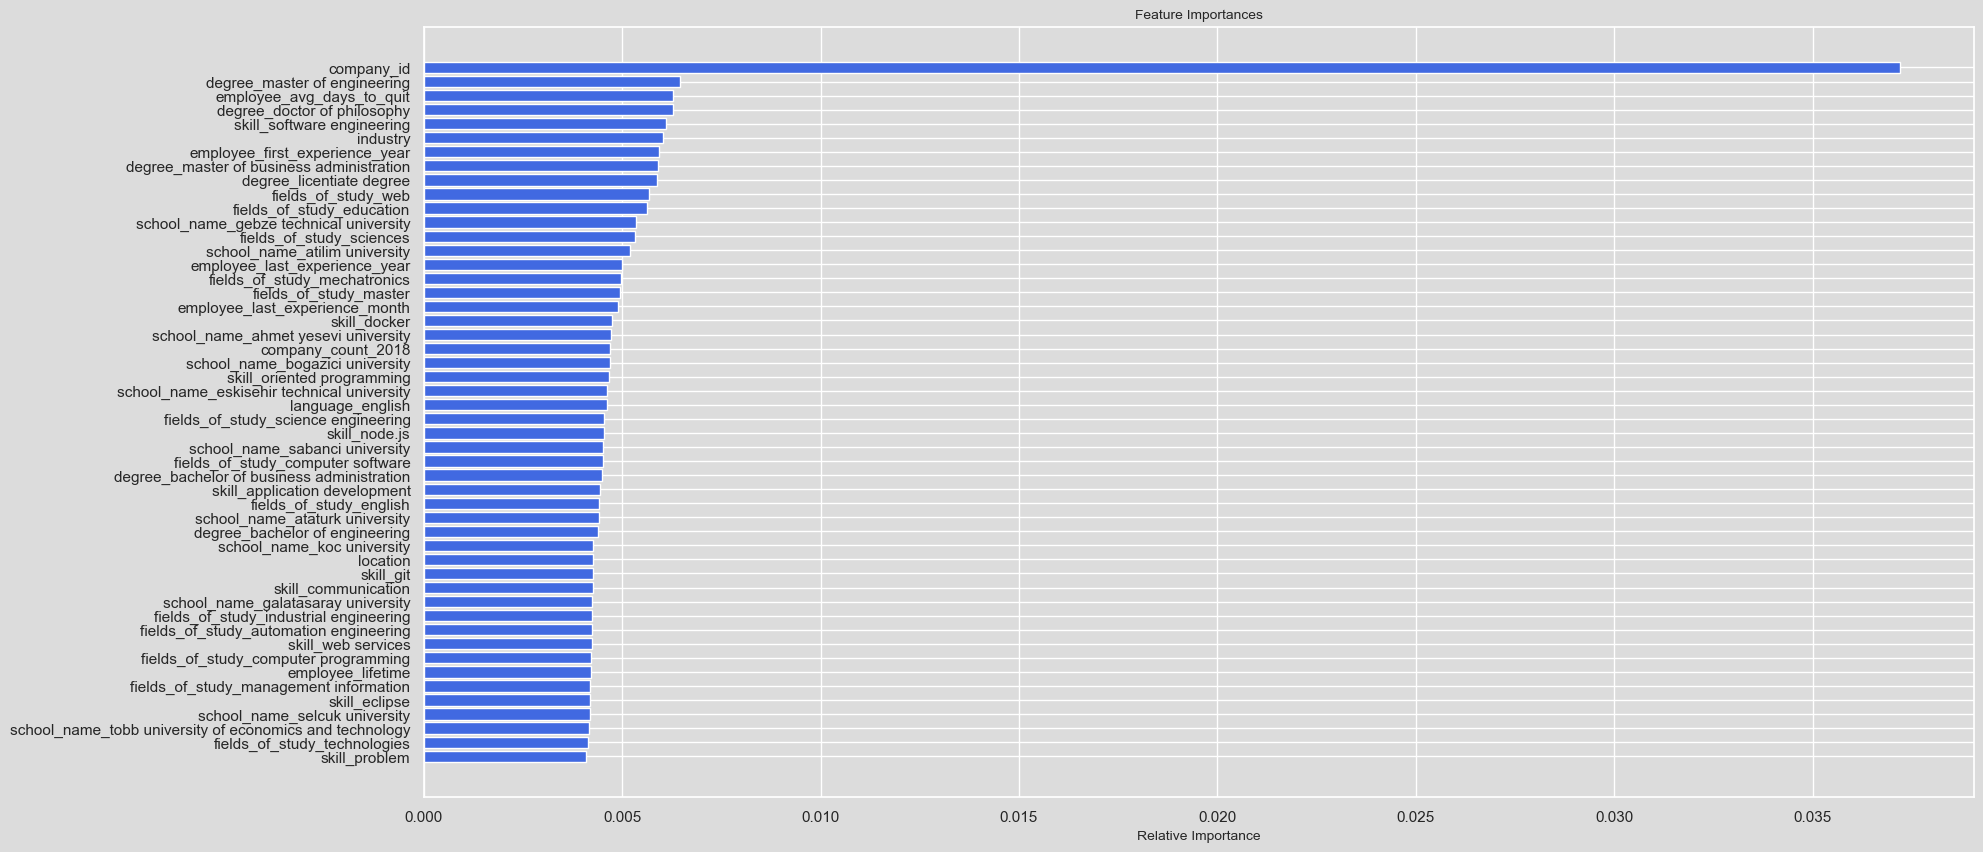

fold accuracy: 0.7883222691611346
-----------------------------------| Fold 2 |-----------------------------------
train: (46391, 289)
val: (6628, 289)
[0]	validation_0-logloss:0.69068
[250]	validation_0-logloss:0.53611
[500]	validation_0-logloss:0.50571
[750]	validation_0-logloss:0.48506
[1000]	validation_0-logloss:0.46936
[1250]	validation_0-logloss:0.45736
[1500]	validation_0-logloss:0.44910
[1750]	validation_0-logloss:0.44371
[2000]	validation_0-logloss:0.44027
[2250]	validation_0-logloss:0.43818
[2500]	validation_0-logloss:0.43766
[2750]	validation_0-logloss:0.43821
[3000]	validation_0-logloss:0.43926
[3009]	validation_0-logloss:0.43935


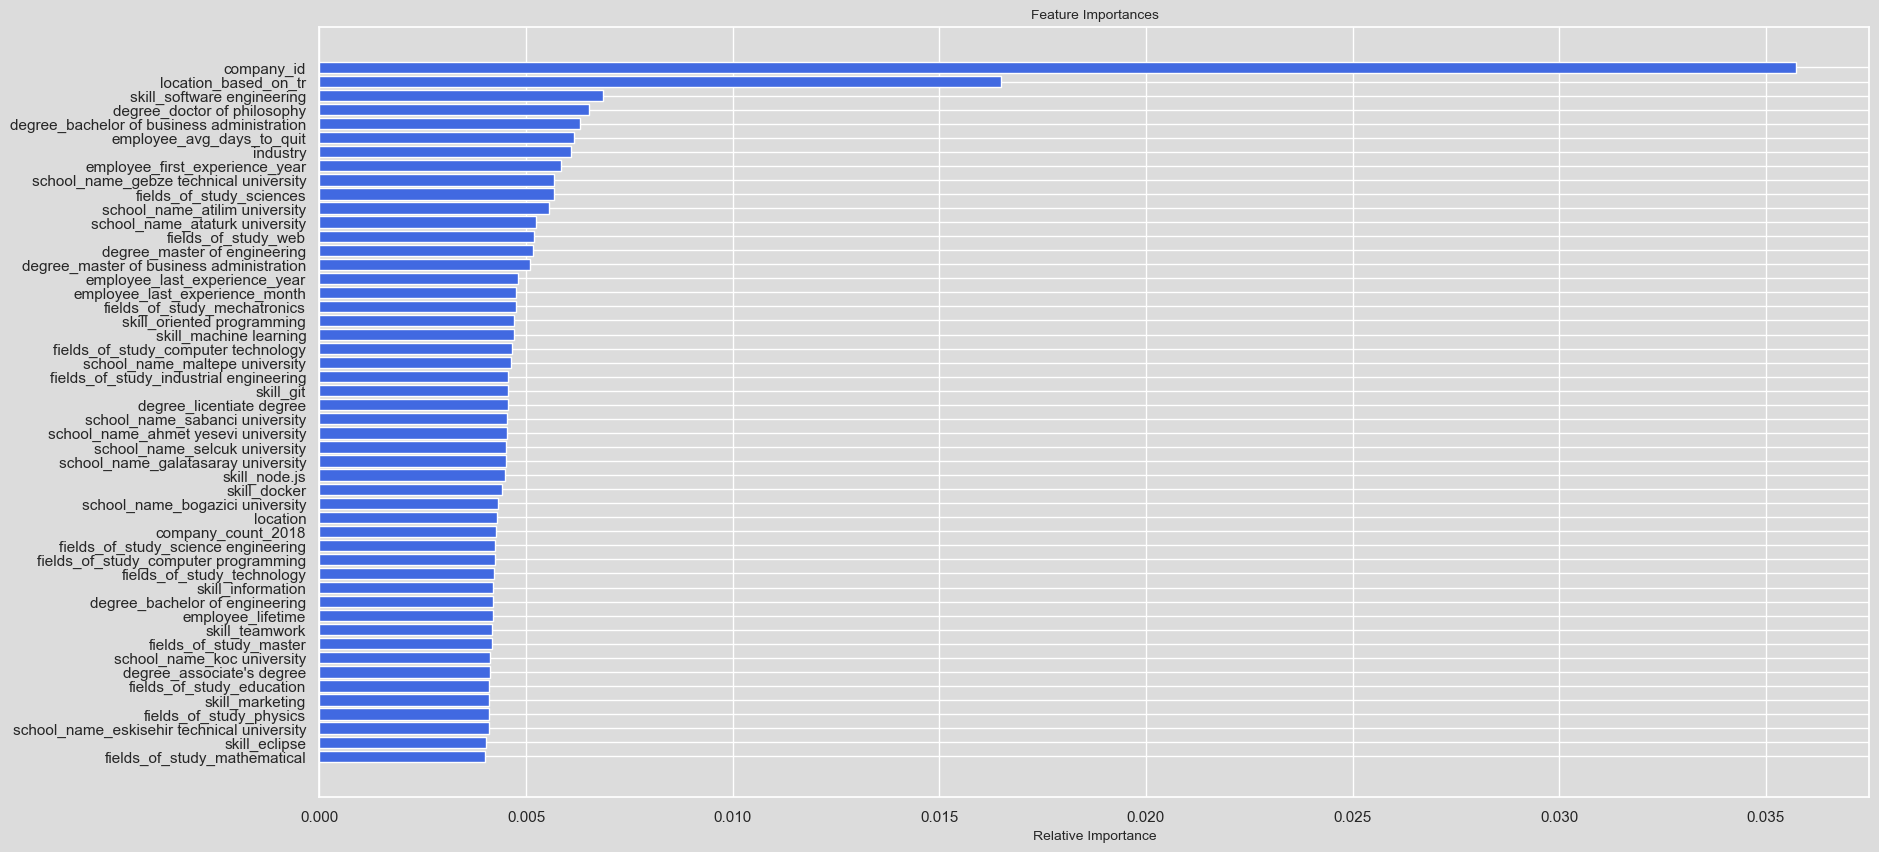

fold accuracy: 0.790132770066385
-----------------------------------| Fold 3 |-----------------------------------
train: (46391, 289)
val: (6628, 289)
[0]	validation_0-logloss:0.69062
[250]	validation_0-logloss:0.53606
[500]	validation_0-logloss:0.50425
[750]	validation_0-logloss:0.48240
[1000]	validation_0-logloss:0.46708
[1250]	validation_0-logloss:0.45574
[1500]	validation_0-logloss:0.44712
[1750]	validation_0-logloss:0.44083
[2000]	validation_0-logloss:0.43701
[2250]	validation_0-logloss:0.43508
[2500]	validation_0-logloss:0.43377
[2750]	validation_0-logloss:0.43320
[3000]	validation_0-logloss:0.43352
[3250]	validation_0-logloss:0.43452
[3314]	validation_0-logloss:0.43497


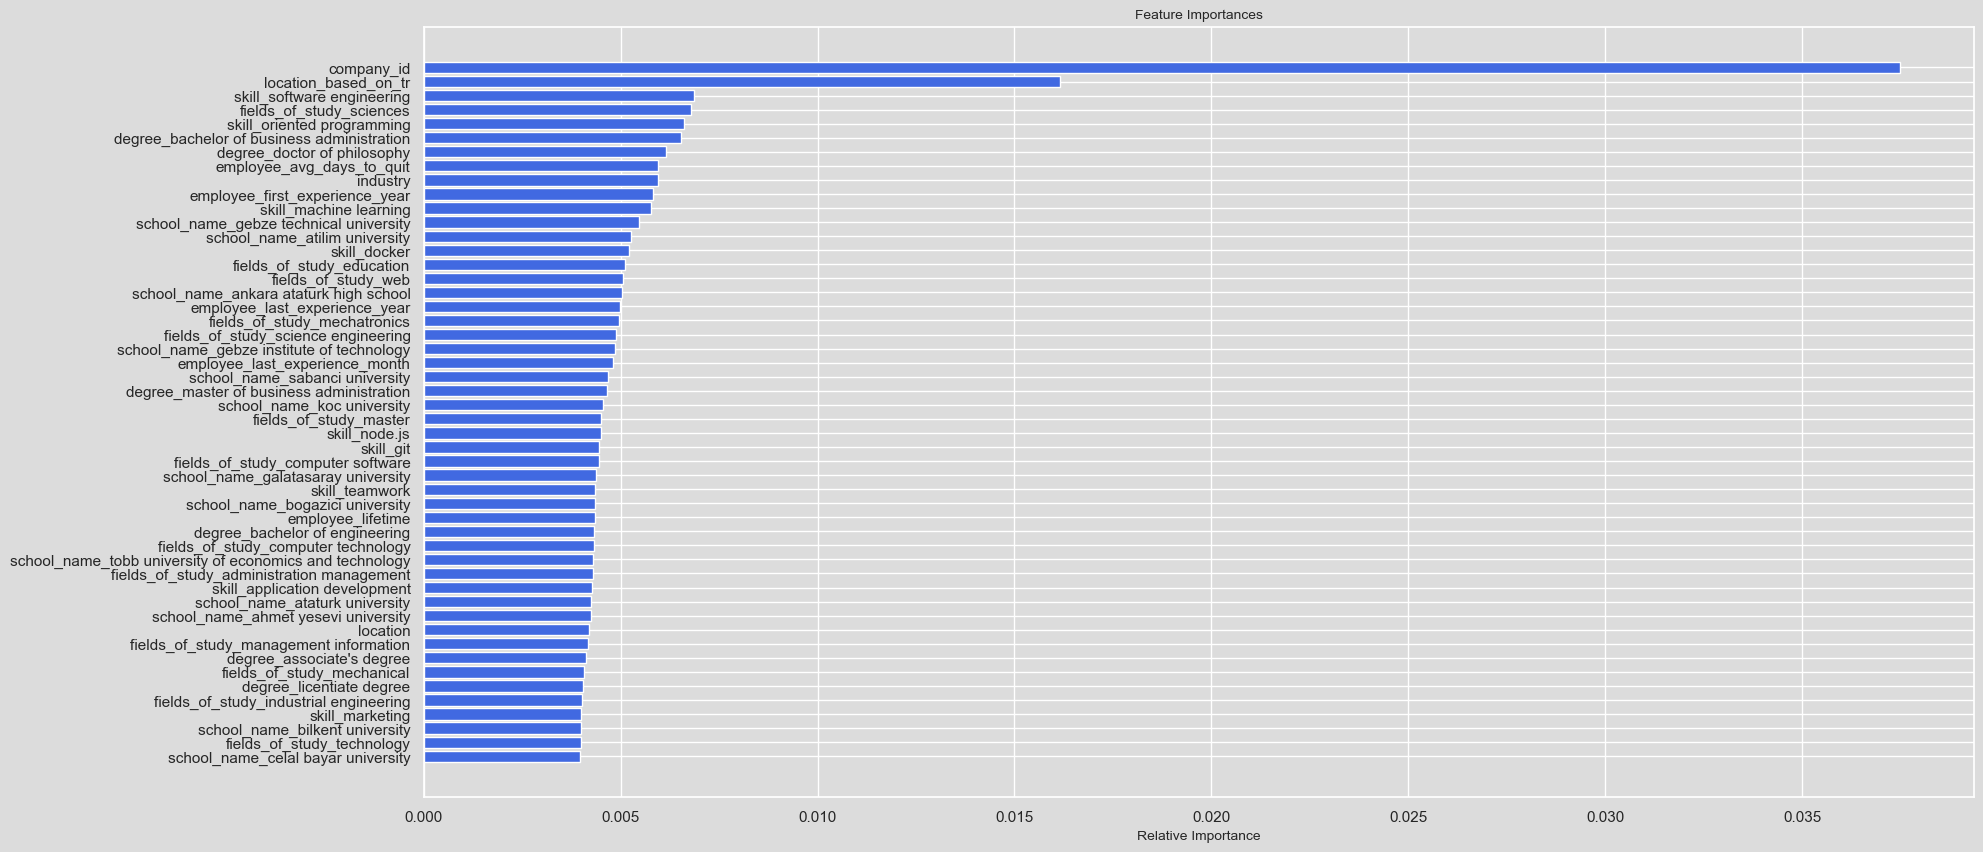

fold accuracy: 0.7936028968014484
-----------------------------------| Fold 4 |-----------------------------------
train: (46392, 289)
val: (6627, 289)
[0]	validation_0-logloss:0.69064
[250]	validation_0-logloss:0.53257
[500]	validation_0-logloss:0.50077
[750]	validation_0-logloss:0.48057
[1000]	validation_0-logloss:0.46570
[1250]	validation_0-logloss:0.45468
[1500]	validation_0-logloss:0.44666
[1750]	validation_0-logloss:0.44181
[2000]	validation_0-logloss:0.43842
[2250]	validation_0-logloss:0.43603
[2500]	validation_0-logloss:0.43560
[2750]	validation_0-logloss:0.43547
[3000]	validation_0-logloss:0.43635
[3250]	validation_0-logloss:0.43744
[3279]	validation_0-logloss:0.43775


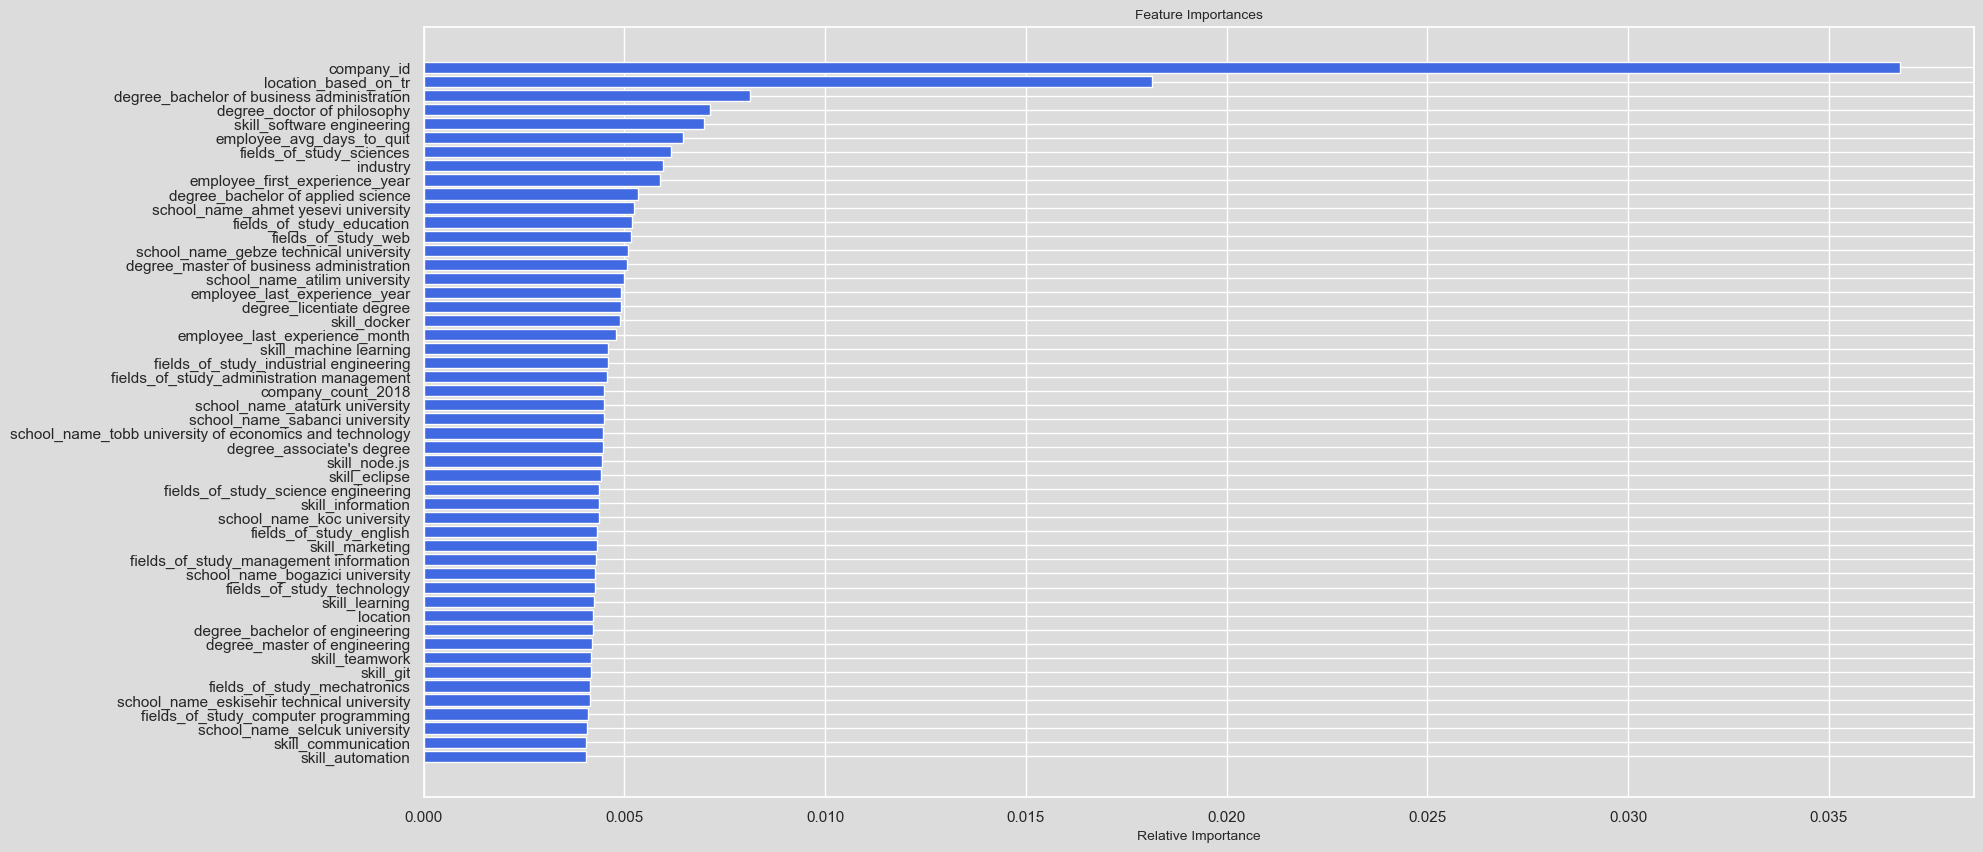

fold accuracy: 0.7867813490267089
-----------------------------------| Fold 5 |-----------------------------------
train: (46392, 289)
val: (6627, 289)
[0]	validation_0-logloss:0.69064
[250]	validation_0-logloss:0.53663
[500]	validation_0-logloss:0.50593
[750]	validation_0-logloss:0.48538
[1000]	validation_0-logloss:0.47106
[1250]	validation_0-logloss:0.45986
[1500]	validation_0-logloss:0.45246
[1750]	validation_0-logloss:0.44752
[2000]	validation_0-logloss:0.44450
[2250]	validation_0-logloss:0.44257
[2500]	validation_0-logloss:0.44230
[2750]	validation_0-logloss:0.44301
[2928]	validation_0-logloss:0.44345


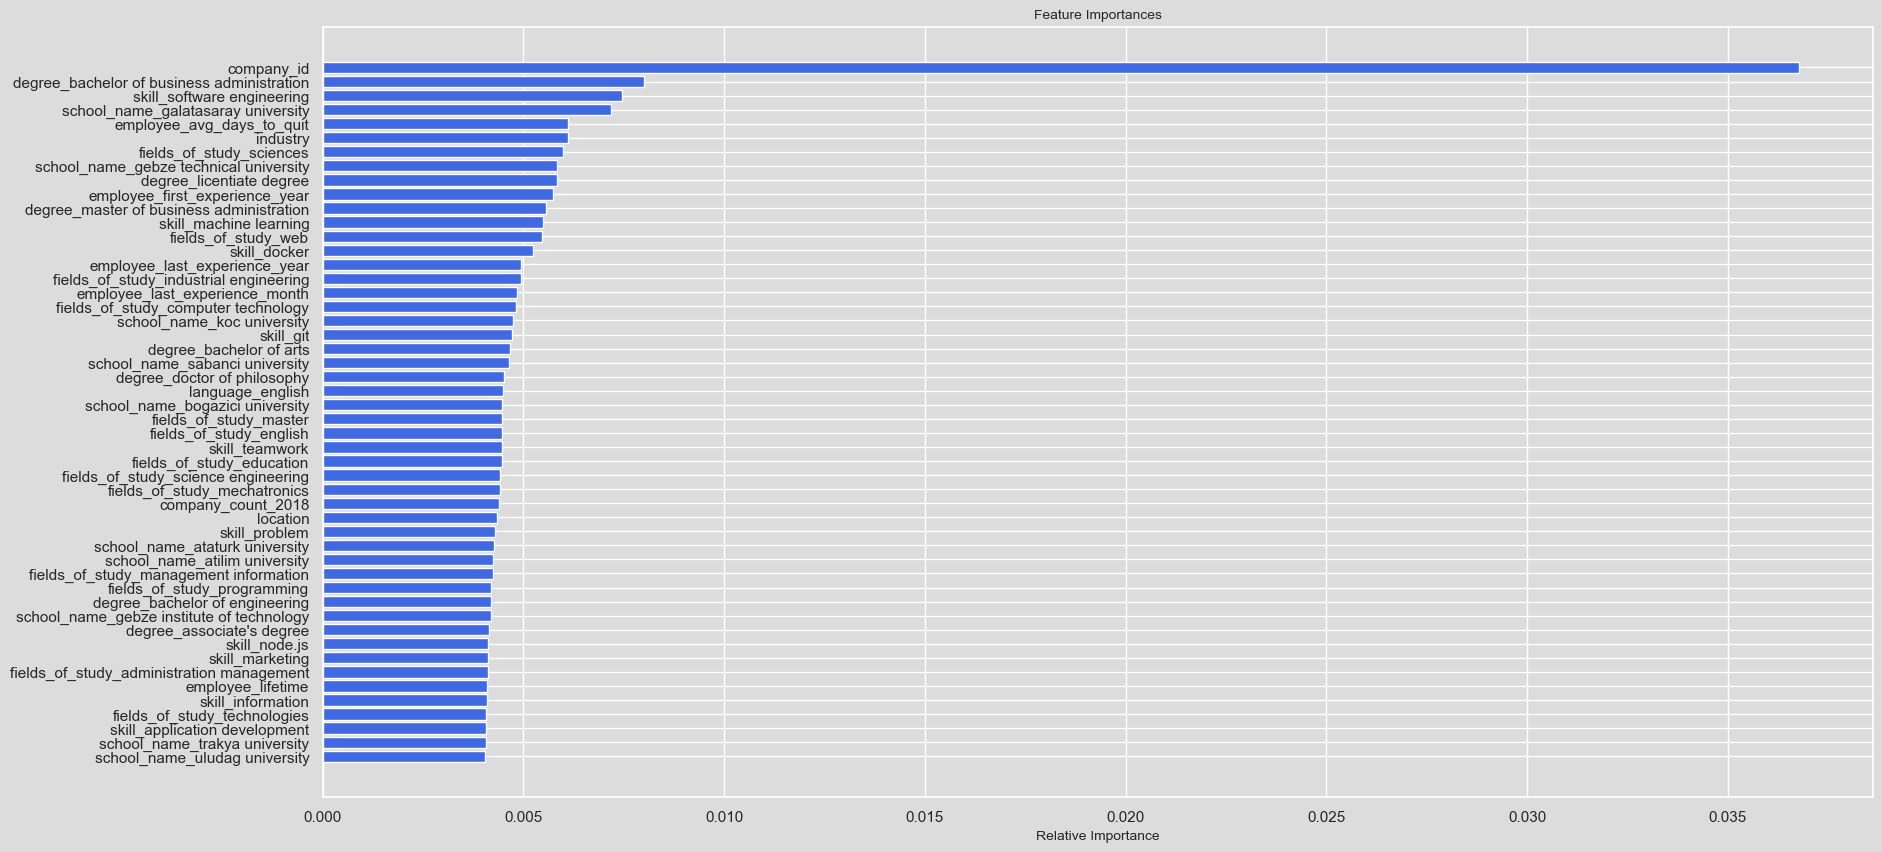

fold accuracy: 0.7863286555002263
-----------------------------------| Fold 6 |-----------------------------------
train: (46392, 289)
val: (6627, 289)
[0]	validation_0-logloss:0.69064
[250]	validation_0-logloss:0.53672
[500]	validation_0-logloss:0.50615
[750]	validation_0-logloss:0.48608
[1000]	validation_0-logloss:0.47104
[1250]	validation_0-logloss:0.45931
[1500]	validation_0-logloss:0.45248
[1750]	validation_0-logloss:0.44827
[2000]	validation_0-logloss:0.44508
[2250]	validation_0-logloss:0.44307
[2500]	validation_0-logloss:0.44189
[2750]	validation_0-logloss:0.44226
[3000]	validation_0-logloss:0.44284
[3047]	validation_0-logloss:0.44299


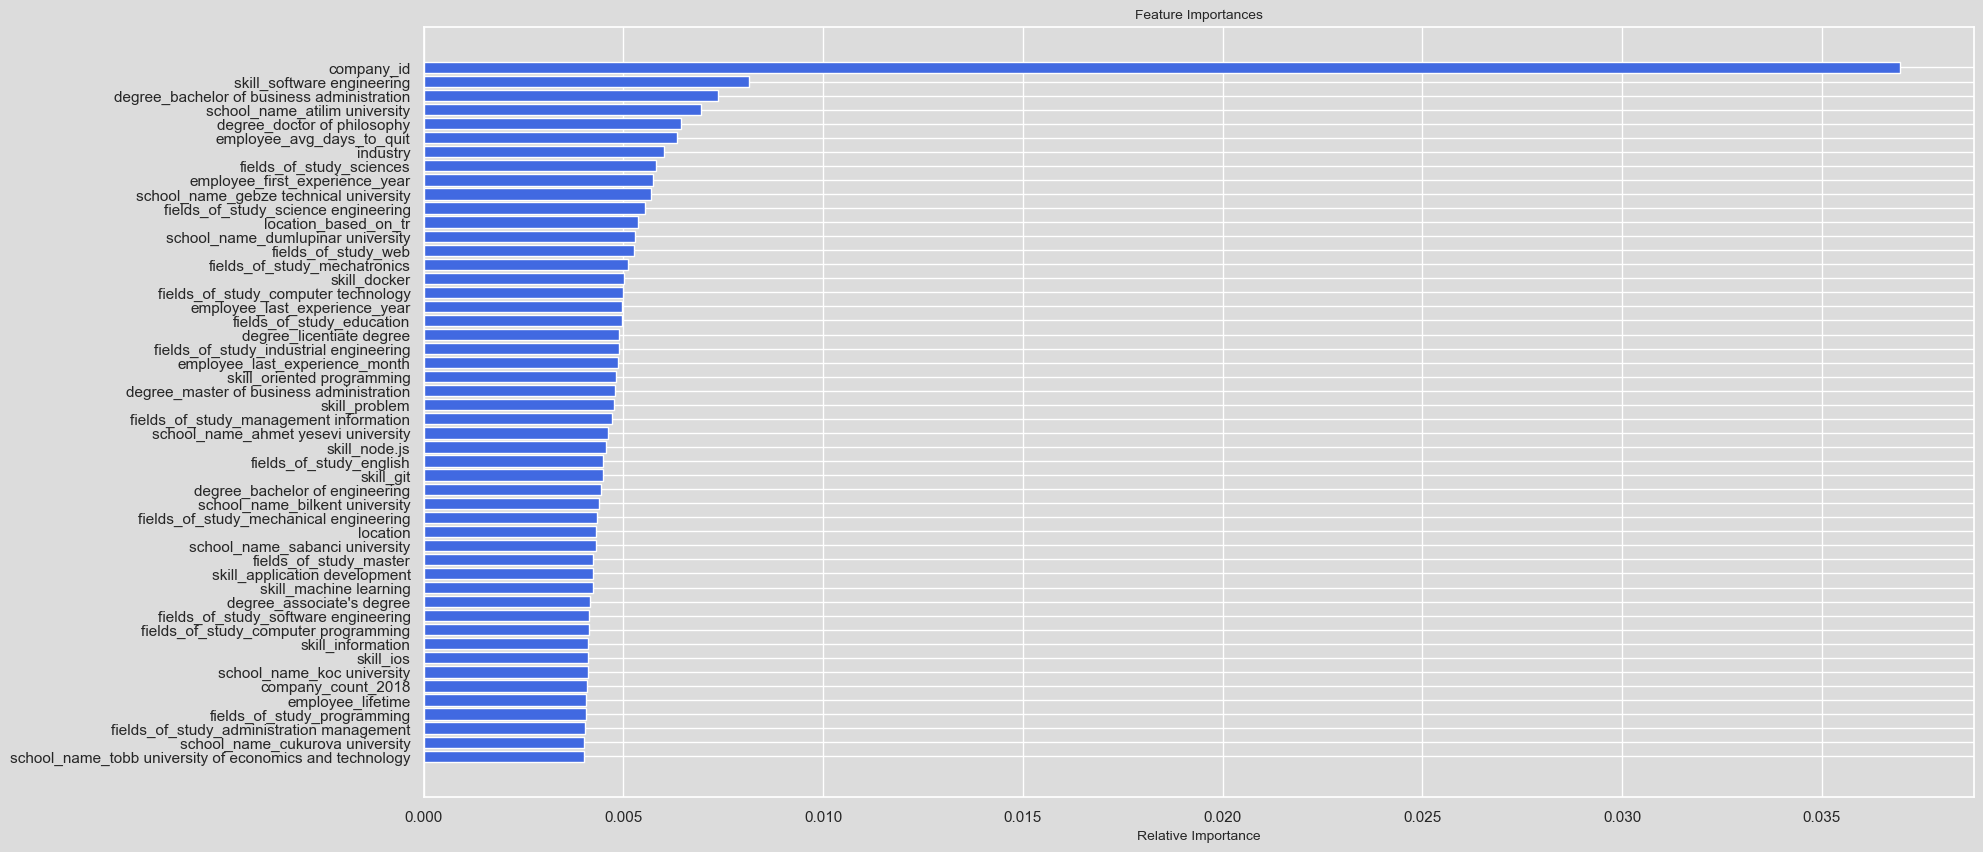

fold accuracy: 0.7879885317639957
-----------------------------------| Fold 7 |-----------------------------------
train: (46392, 289)
val: (6627, 289)
[0]	validation_0-logloss:0.69063
[250]	validation_0-logloss:0.53351
[500]	validation_0-logloss:0.50029
[750]	validation_0-logloss:0.47795
[1000]	validation_0-logloss:0.46121
[1250]	validation_0-logloss:0.44840
[1500]	validation_0-logloss:0.43927
[1750]	validation_0-logloss:0.43291
[2000]	validation_0-logloss:0.42859
[2250]	validation_0-logloss:0.42637
[2500]	validation_0-logloss:0.42501
[2750]	validation_0-logloss:0.42496
[3000]	validation_0-logloss:0.42528
[3196]	validation_0-logloss:0.42596


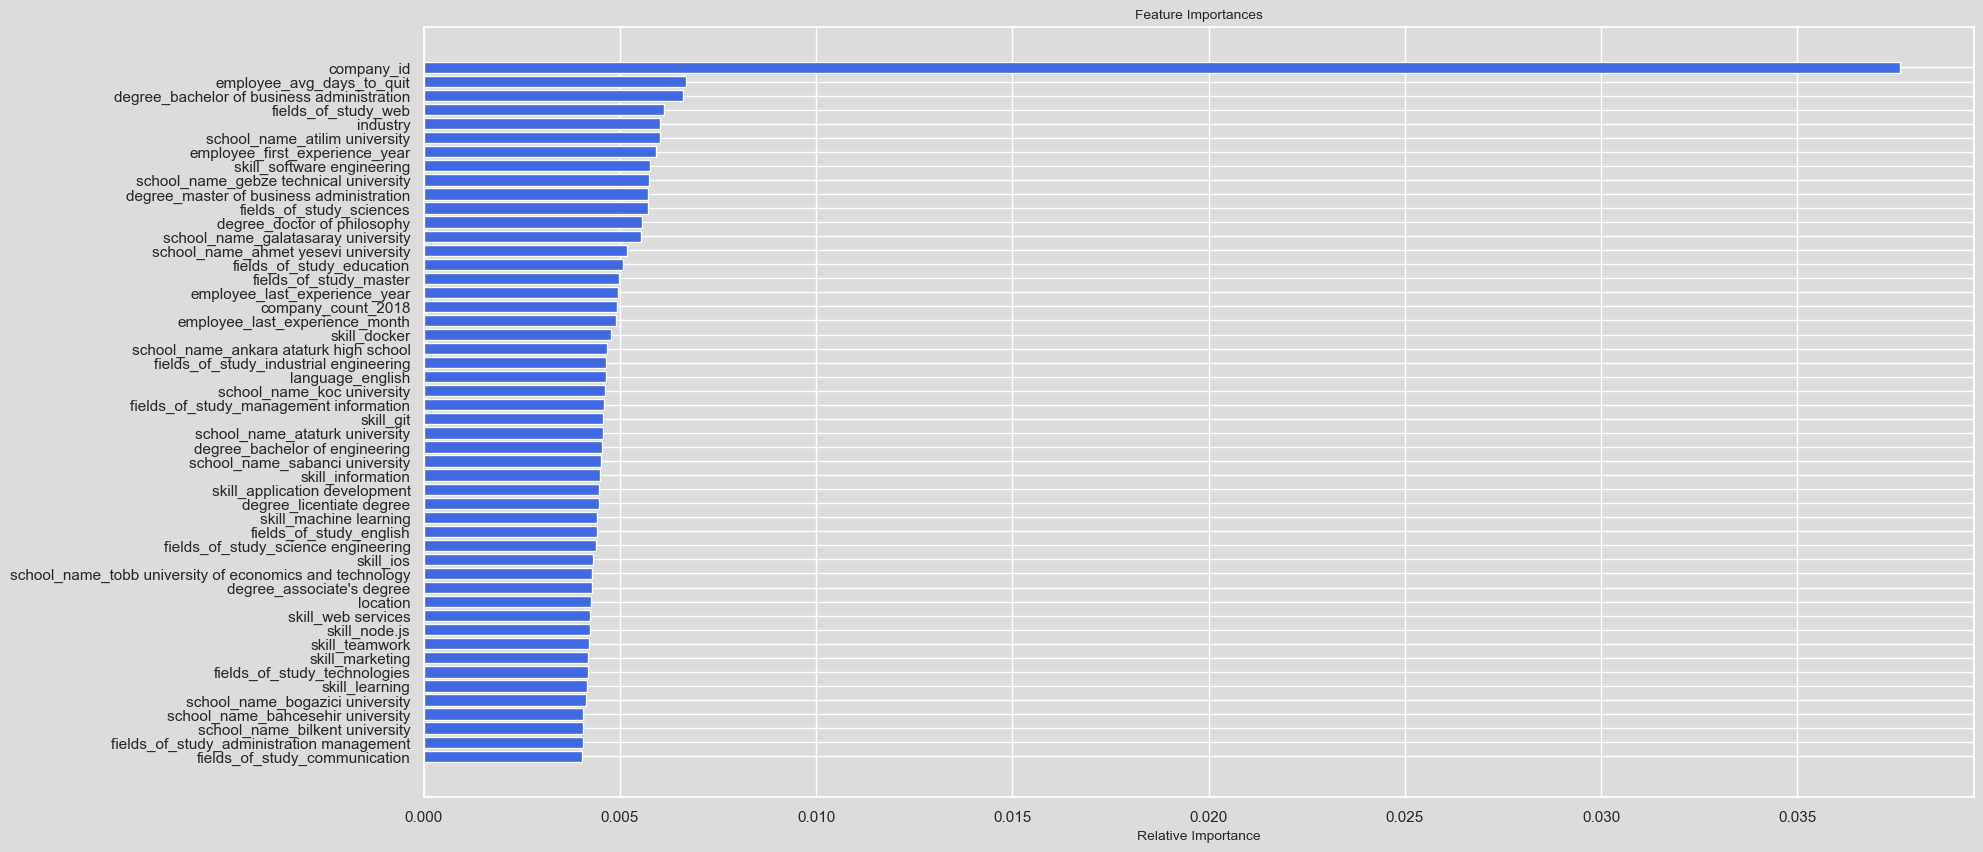

fold accuracy: 0.8006639505055078
-----------------------------------| Fold 8 |-----------------------------------
train: (46392, 289)
val: (6627, 289)
[0]	validation_0-logloss:0.69062
[250]	validation_0-logloss:0.53628
[500]	validation_0-logloss:0.50458
[750]	validation_0-logloss:0.48299
[1000]	validation_0-logloss:0.46844
[1250]	validation_0-logloss:0.45732
[1500]	validation_0-logloss:0.44894
[1750]	validation_0-logloss:0.44433
[2000]	validation_0-logloss:0.44157
[2250]	validation_0-logloss:0.44022
[2500]	validation_0-logloss:0.43985
[2750]	validation_0-logloss:0.44009
[3000]	validation_0-logloss:0.44111
[3103]	validation_0-logloss:0.44179


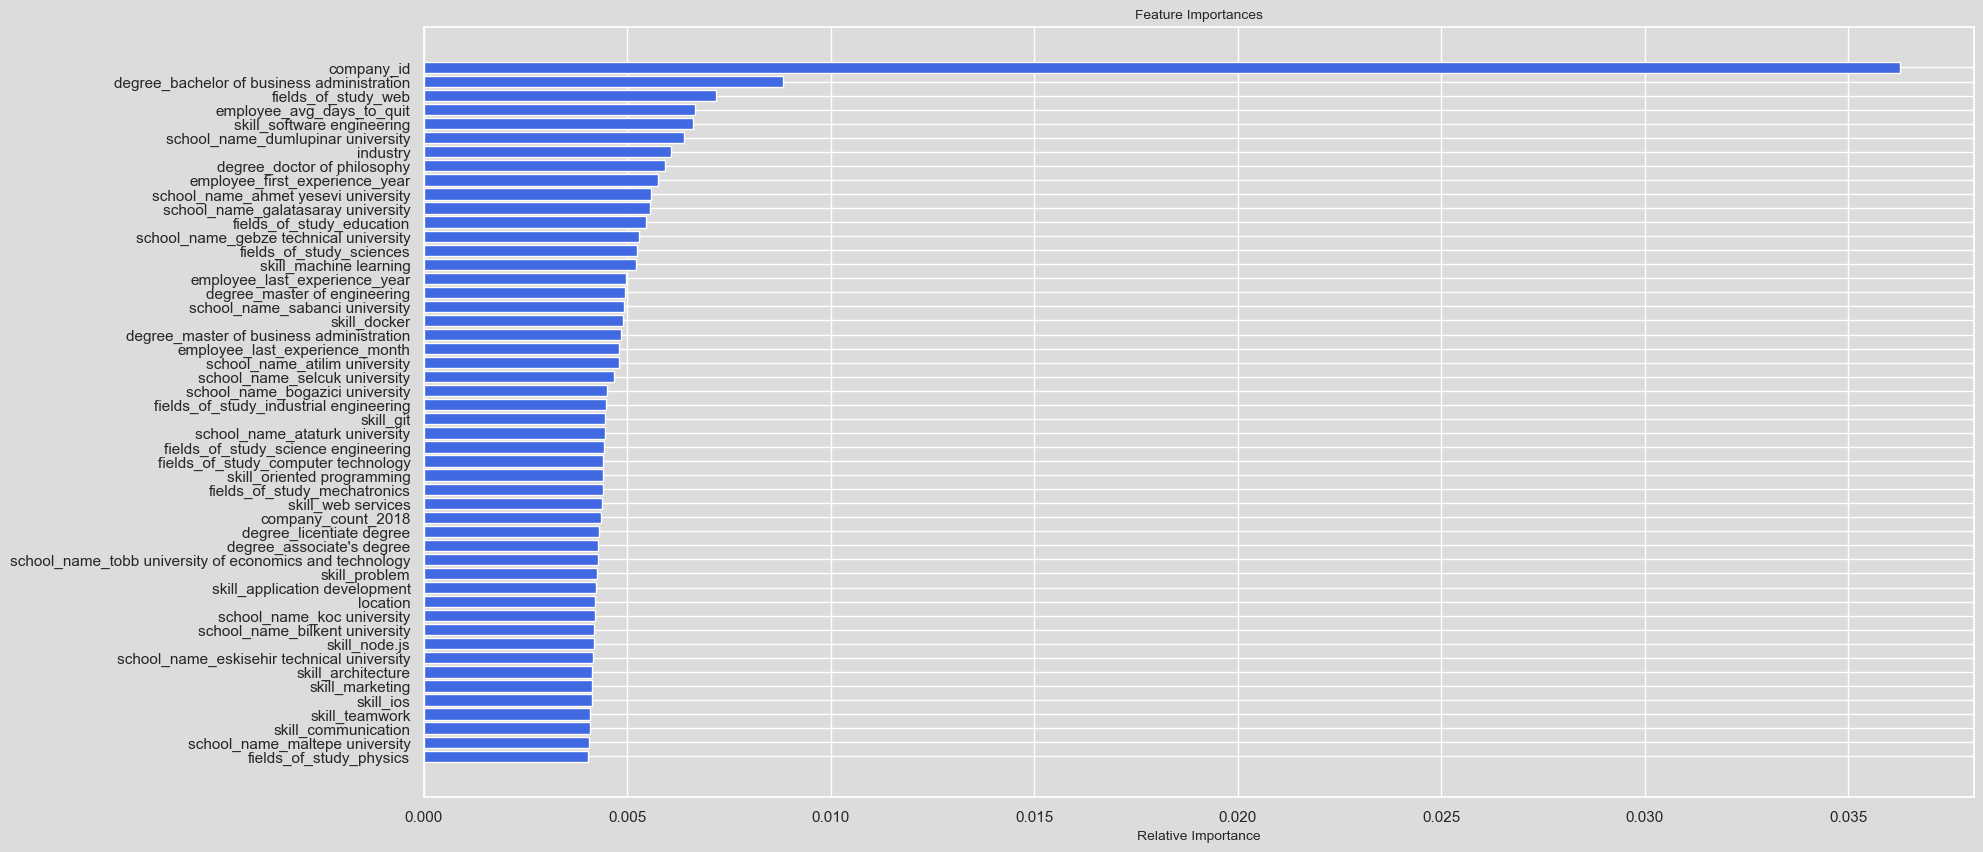

fold accuracy: 0.7875358382375132
accuracy: 0.7901695618551839
folds avg accuracy: 0.790169532632865
folds std accuracy: 0.004517462867517659


In [8]:
xgb1_scores, xgb1_train_scores = get_model_scores(xgb1, skf, train_set, test_set, 'moved_after_2019', config.n_folds, True)

-----------------------------------| Fold 1 |-----------------------------------
train: (46391, 289)
val: (6628, 289)
0:	learn: 0.6577784	test: 0.6374472	best: 0.6374472 (0)	total: 235ms	remaining: 19m 33s
250:	learn: 0.7785777	test: 0.7371756	best: 0.7373265 (248)	total: 34.4s	remaining: 10m 51s
500:	learn: 0.8164730	test: 0.7506035	best: 0.7507544 (498)	total: 1m 9s	remaining: 10m 24s
750:	learn: 0.8565886	test: 0.7626735	best: 0.7643331 (725)	total: 1m 45s	remaining: 9m 54s
1000:	learn: 0.8922851	test: 0.7724804	best: 0.7724804 (1000)	total: 2m 20s	remaining: 9m 22s
1250:	learn: 0.9153068	test: 0.7780628	best: 0.7785154 (1238)	total: 2m 57s	remaining: 8m 51s
1500:	learn: 0.9338234	test: 0.7812311	best: 0.7819855 (1489)	total: 3m 33s	remaining: 8m 16s
1750:	learn: 0.9487832	test: 0.7836451	best: 0.7840978 (1748)	total: 4m 9s	remaining: 7m 42s
2000:	learn: 0.9604018	test: 0.7839469	best: 0.7851539 (1988)	total: 4m 45s	remaining: 7m 7s
2250:	learn: 0.9698864	test: 0.7856065	best: 0.786

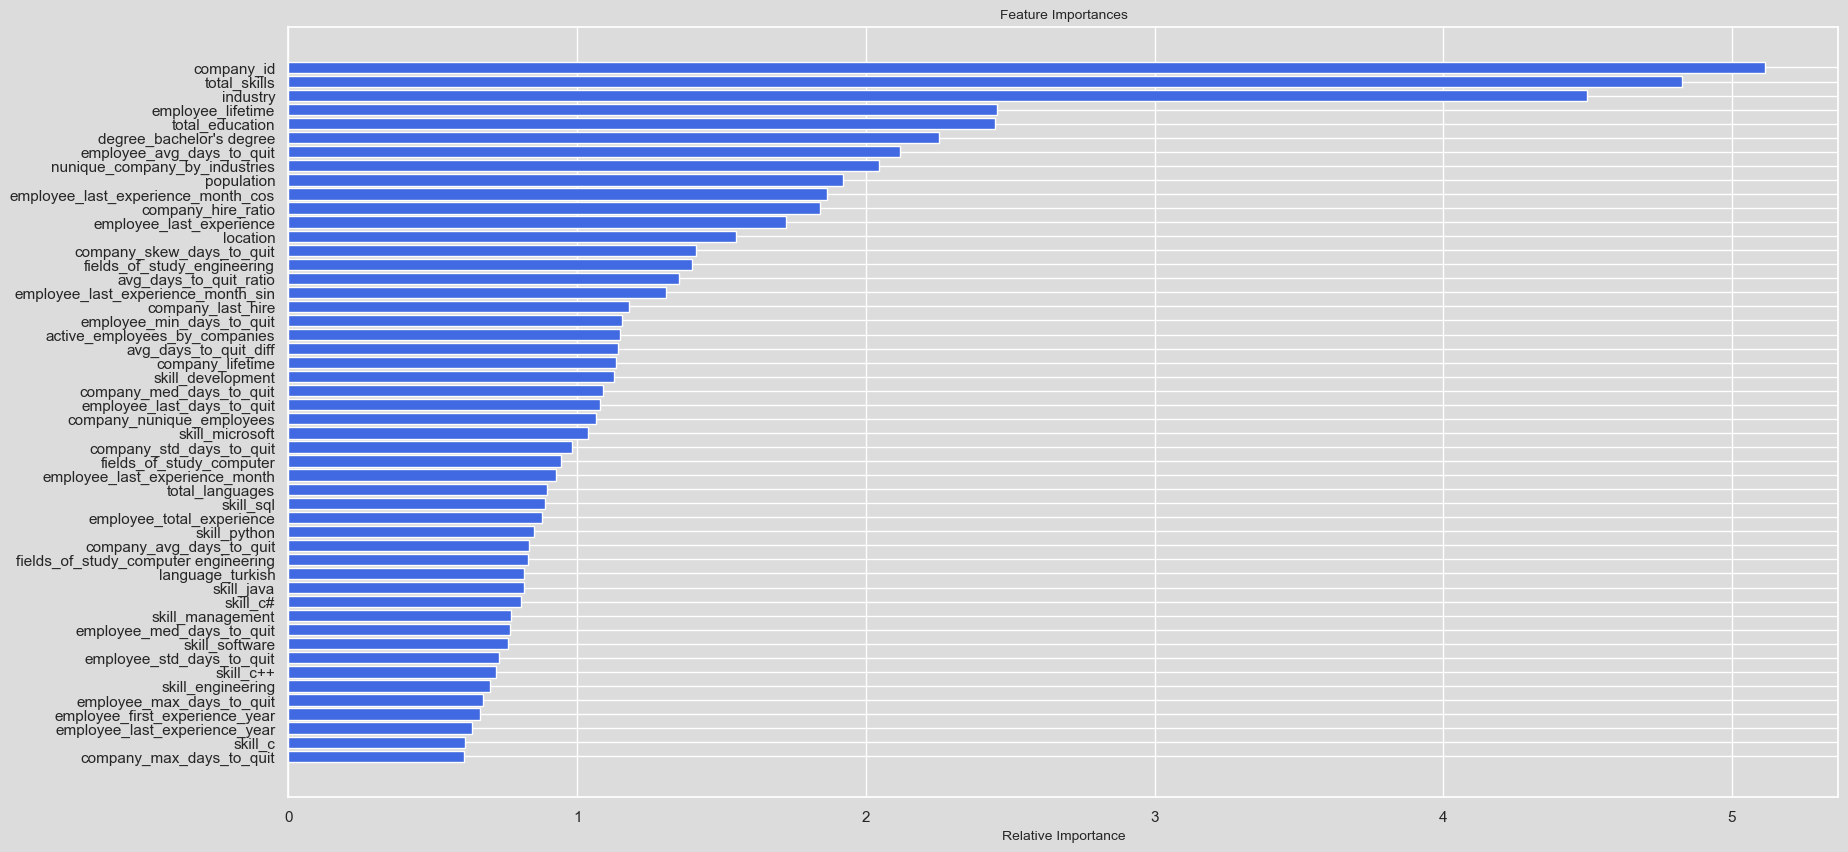

fold accuracy: 0.791792395896198
-----------------------------------| Fold 2 |-----------------------------------
train: (46391, 289)
val: (6628, 289)
0:	learn: 0.6509237	test: 0.6347314	best: 0.6347314 (0)	total: 150ms	remaining: 12m 30s
250:	learn: 0.7772844	test: 0.7454737	best: 0.7454737 (250)	total: 34.8s	remaining: 10m 59s
500:	learn: 0.8178742	test: 0.7552806	best: 0.7552806 (462)	total: 1m 12s	remaining: 10m 47s
750:	learn: 0.8571275	test: 0.7647858	best: 0.7652384 (747)	total: 1m 50s	remaining: 10m 24s
1000:	learn: 0.8905391	test: 0.7717260	best: 0.7718769 (997)	total: 2m 27s	remaining: 9m 47s
1250:	learn: 0.9157380	test: 0.7776101	best: 0.7777610 (1238)	total: 3m 3s	remaining: 9m 10s
1500:	learn: 0.9344700	test: 0.7833434	best: 0.7845504 (1446)	total: 3m 39s	remaining: 8m 31s
1750:	learn: 0.9485245	test: 0.7859083	best: 0.7866626 (1629)	total: 4m 15s	remaining: 7m 53s
2000:	learn: 0.9604449	test: 0.7878696	best: 0.7886240 (1996)	total: 4m 51s	remaining: 7m 16s
2250:	learn: 0.

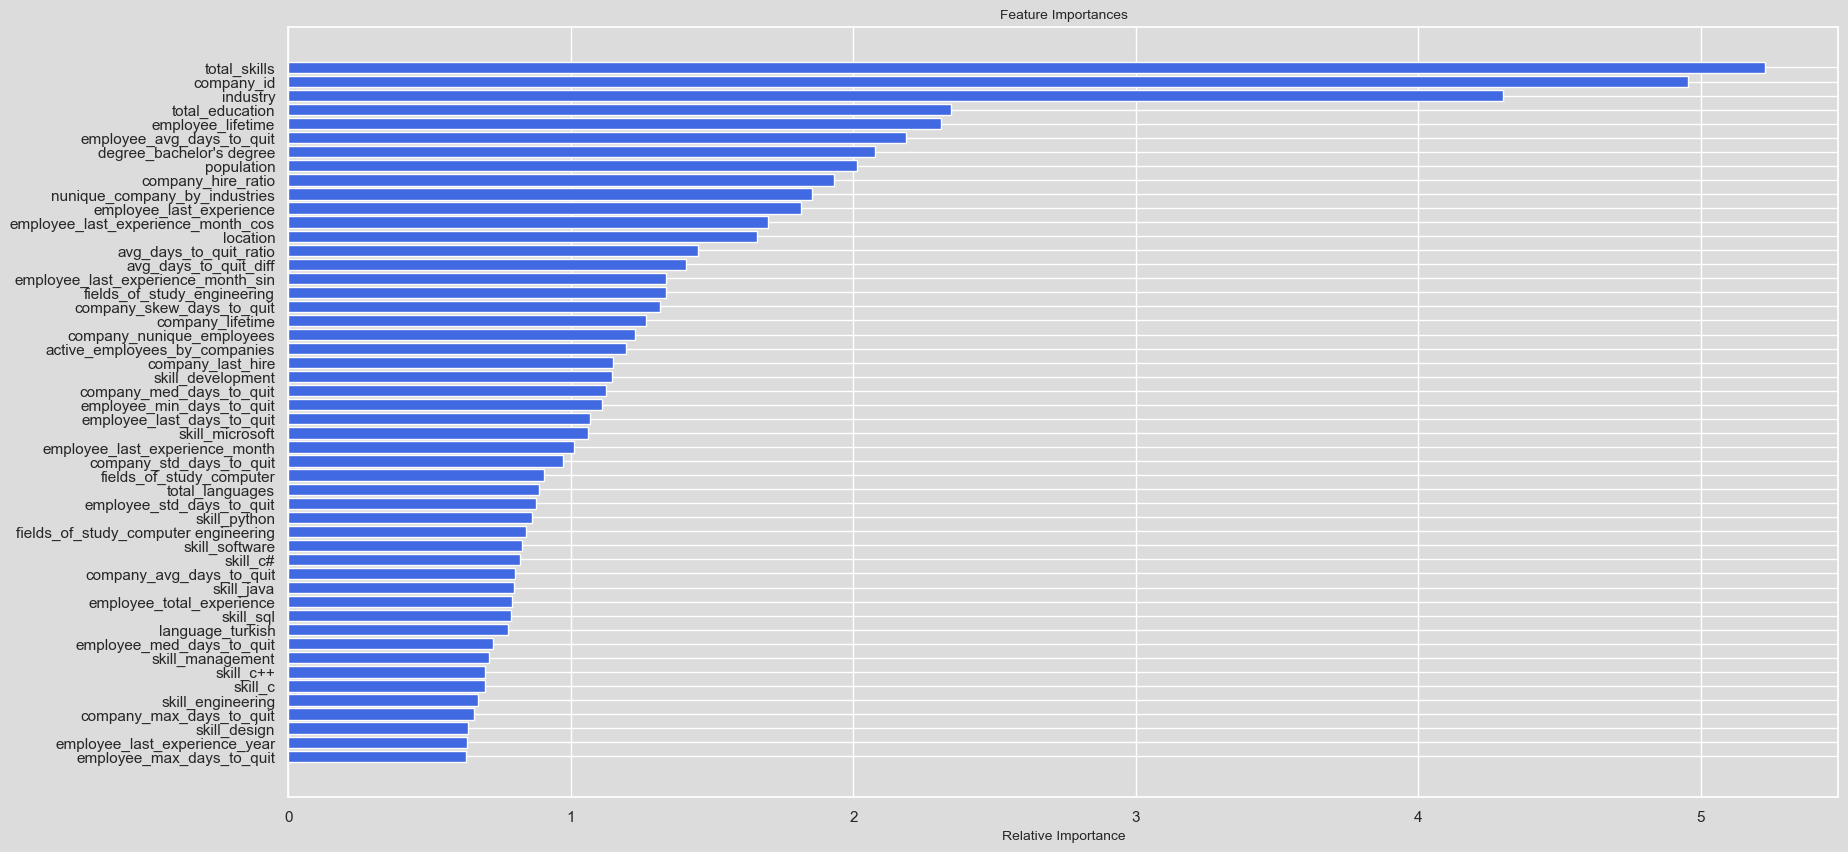

fold accuracy: 0.7952625226312613
-----------------------------------| Fold 3 |-----------------------------------
train: (46391, 289)
val: (6628, 289)
0:	learn: 0.6326874	test: 0.6289982	best: 0.6289982 (0)	total: 53.8ms	remaining: 4m 29s
250:	learn: 0.7765084	test: 0.7347616	best: 0.7355160 (239)	total: 36.6s	remaining: 11m 33s
500:	learn: 0.8129594	test: 0.7474351	best: 0.7480386 (477)	total: 1m 12s	remaining: 10m 49s
750:	learn: 0.8550365	test: 0.7575438	best: 0.7578455 (742)	total: 1m 49s	remaining: 10m 17s
1000:	learn: 0.8918756	test: 0.7694629	best: 0.7694629 (999)	total: 2m 25s	remaining: 9m 40s
1250:	learn: 0.9151128	test: 0.7741400	best: 0.7745926 (1241)	total: 3m 1s	remaining: 9m 3s
1500:	learn: 0.9344916	test: 0.7786663	best: 0.7791189 (1416)	total: 3m 39s	remaining: 8m 30s
1750:	learn: 0.9502705	test: 0.7798733	best: 0.7812311 (1611)	total: 4m 16s	remaining: 7m 55s
2000:	learn: 0.9610485	test: 0.7809294	best: 0.7821364 (1962)	total: 4m 53s	remaining: 7m 19s
2250:	learn: 0.

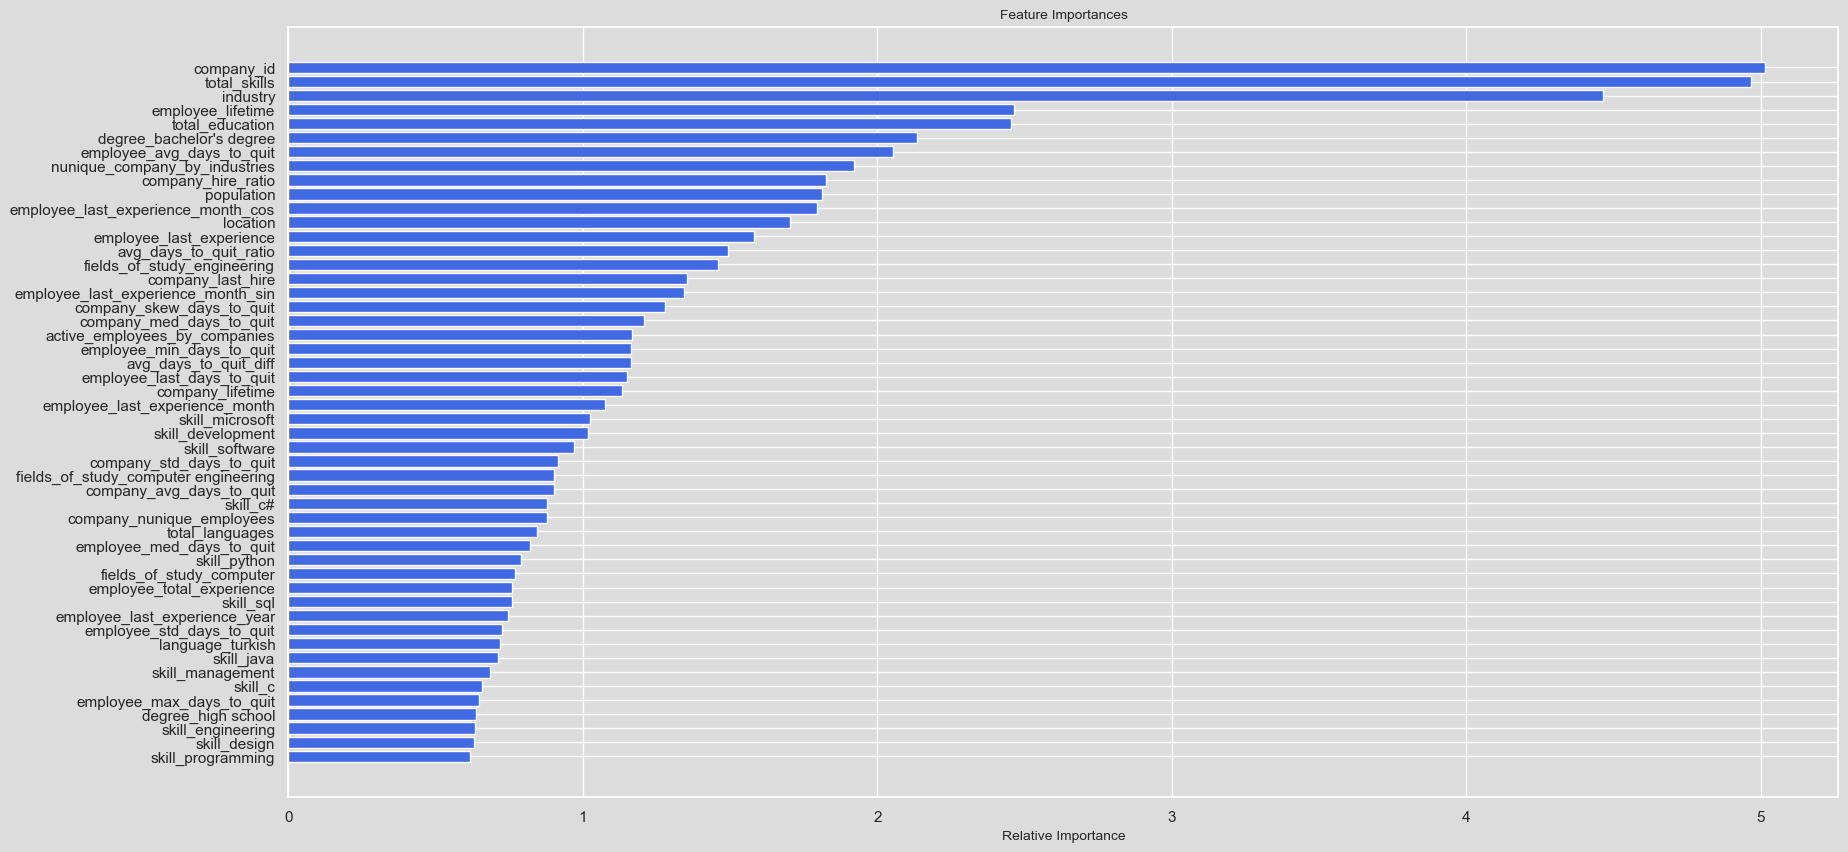

fold accuracy: 0.7892275196137598
-----------------------------------| Fold 4 |-----------------------------------
train: (46392, 289)
val: (6627, 289)
0:	learn: 0.6474608	test: 0.6381470	best: 0.6381470 (0)	total: 203ms	remaining: 16m 52s
250:	learn: 0.7802207	test: 0.7455862	best: 0.7457371 (246)	total: 33.3s	remaining: 10m 30s
500:	learn: 0.8214347	test: 0.7550928	best: 0.7552437 (499)	total: 1m 8s	remaining: 10m 12s
750:	learn: 0.8600621	test: 0.7644485	best: 0.7645994 (745)	total: 1m 42s	remaining: 9m 38s
1000:	learn: 0.8936455	test: 0.7733514	best: 0.7736532 (998)	total: 2m 16s	remaining: 9m 4s
1250:	learn: 0.9176582	test: 0.7780293	best: 0.7784820 (1232)	total: 2m 52s	remaining: 8m 36s
1500:	learn: 0.9370150	test: 0.7814999	best: 0.7814999 (1500)	total: 3m 28s	remaining: 8m 6s
1750:	learn: 0.9516943	test: 0.7836125	best: 0.7845179 (1737)	total: 4m 4s	remaining: 7m 34s
2000:	learn: 0.9627522	test: 0.7864796	best: 0.7869322 (1972)	total: 4m 43s	remaining: 7m 4s
2250:	learn: 0.9703

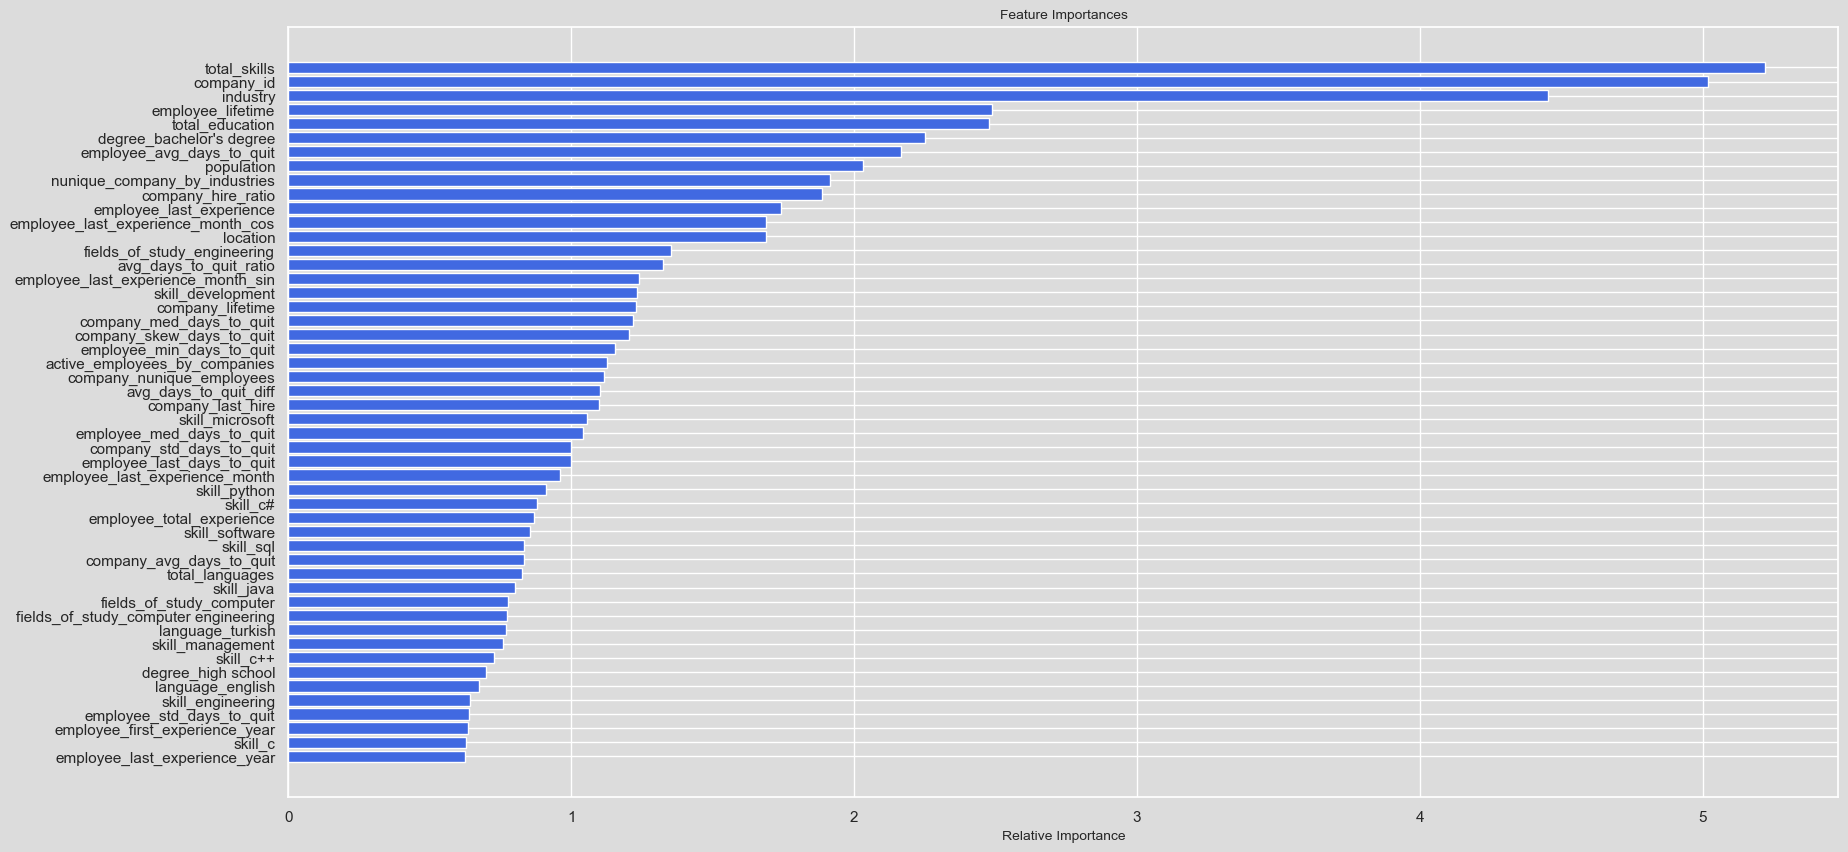

fold accuracy: 0.7907046929228913
-----------------------------------| Fold 5 |-----------------------------------
train: (46392, 289)
val: (6627, 289)
0:	learn: 0.6501336	test: 0.6434284	best: 0.6434284 (0)	total: 148ms	remaining: 12m 22s
250:	learn: 0.7759959	test: 0.7454353	best: 0.7457371 (248)	total: 34.9s	remaining: 10m 59s
500:	learn: 0.8159381	test: 0.7581108	best: 0.7581108 (498)	total: 1m 10s	remaining: 10m 34s
750:	learn: 0.8571090	test: 0.7650521	best: 0.7658065 (742)	total: 1m 46s	remaining: 10m 2s
1000:	learn: 0.8924599	test: 0.7719934	best: 0.7719934 (1000)	total: 2m 22s	remaining: 9m 27s
1250:	learn: 0.9175936	test: 0.7760676	best: 0.7769730 (1236)	total: 2m 58s	remaining: 8m 53s
1500:	learn: 0.9359803	test: 0.7795383	best: 0.7802927 (1454)	total: 3m 33s	remaining: 8m 18s
1750:	learn: 0.9498836	test: 0.7828580	best: 0.7839143 (1674)	total: 4m 9s	remaining: 7m 43s
2000:	learn: 0.9604673	test: 0.7858760	best: 0.7875358 (1904)	total: 4m 46s	remaining: 7m 8s
2250:	learn: 0.

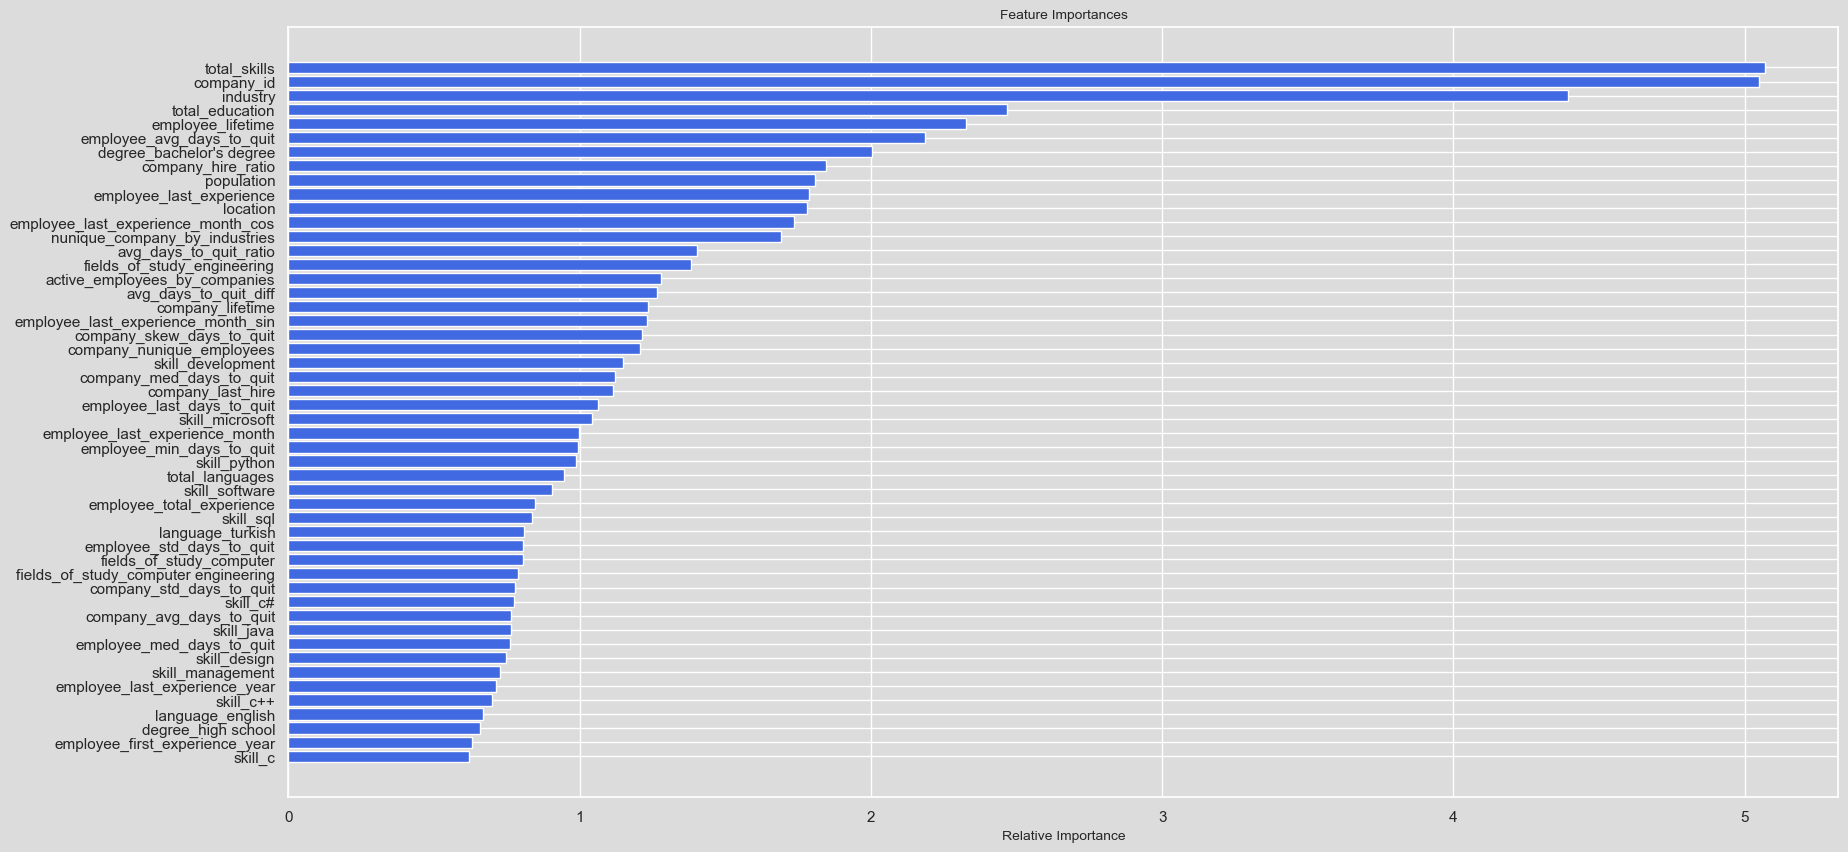

fold accuracy: 0.7907046929228913
-----------------------------------| Fold 6 |-----------------------------------
train: (46392, 289)
val: (6627, 289)
0:	learn: 0.6535178	test: 0.6404104	best: 0.6404104 (0)	total: 171ms	remaining: 14m 14s
250:	learn: 0.7729781	test: 0.7413611	best: 0.7419647 (243)	total: 34.6s	remaining: 10m 55s
500:	learn: 0.8154208	test: 0.7540365	best: 0.7540365 (500)	total: 1m 10s	remaining: 10m 32s
750:	learn: 0.8550181	test: 0.7632413	best: 0.7632413 (750)	total: 1m 46s	remaining: 10m 3s
1000:	learn: 0.8913821	test: 0.7698808	best: 0.7700317 (973)	total: 2m 23s	remaining: 9m 32s
1250:	learn: 0.9168607	test: 0.7748604	best: 0.7750113 (1183)	total: 3m	remaining: 8m 59s
1500:	learn: 0.9349241	test: 0.7787838	best: 0.7789347 (1460)	total: 3m 36s	remaining: 8m 24s
1750:	learn: 0.9495603	test: 0.7818017	best: 0.7818017 (1749)	total: 4m 12s	remaining: 7m 48s
2000:	learn: 0.9607907	test: 0.7849706	best: 0.7852724 (1997)	total: 4m 48s	remaining: 7m 12s
2250:	learn: 0.969

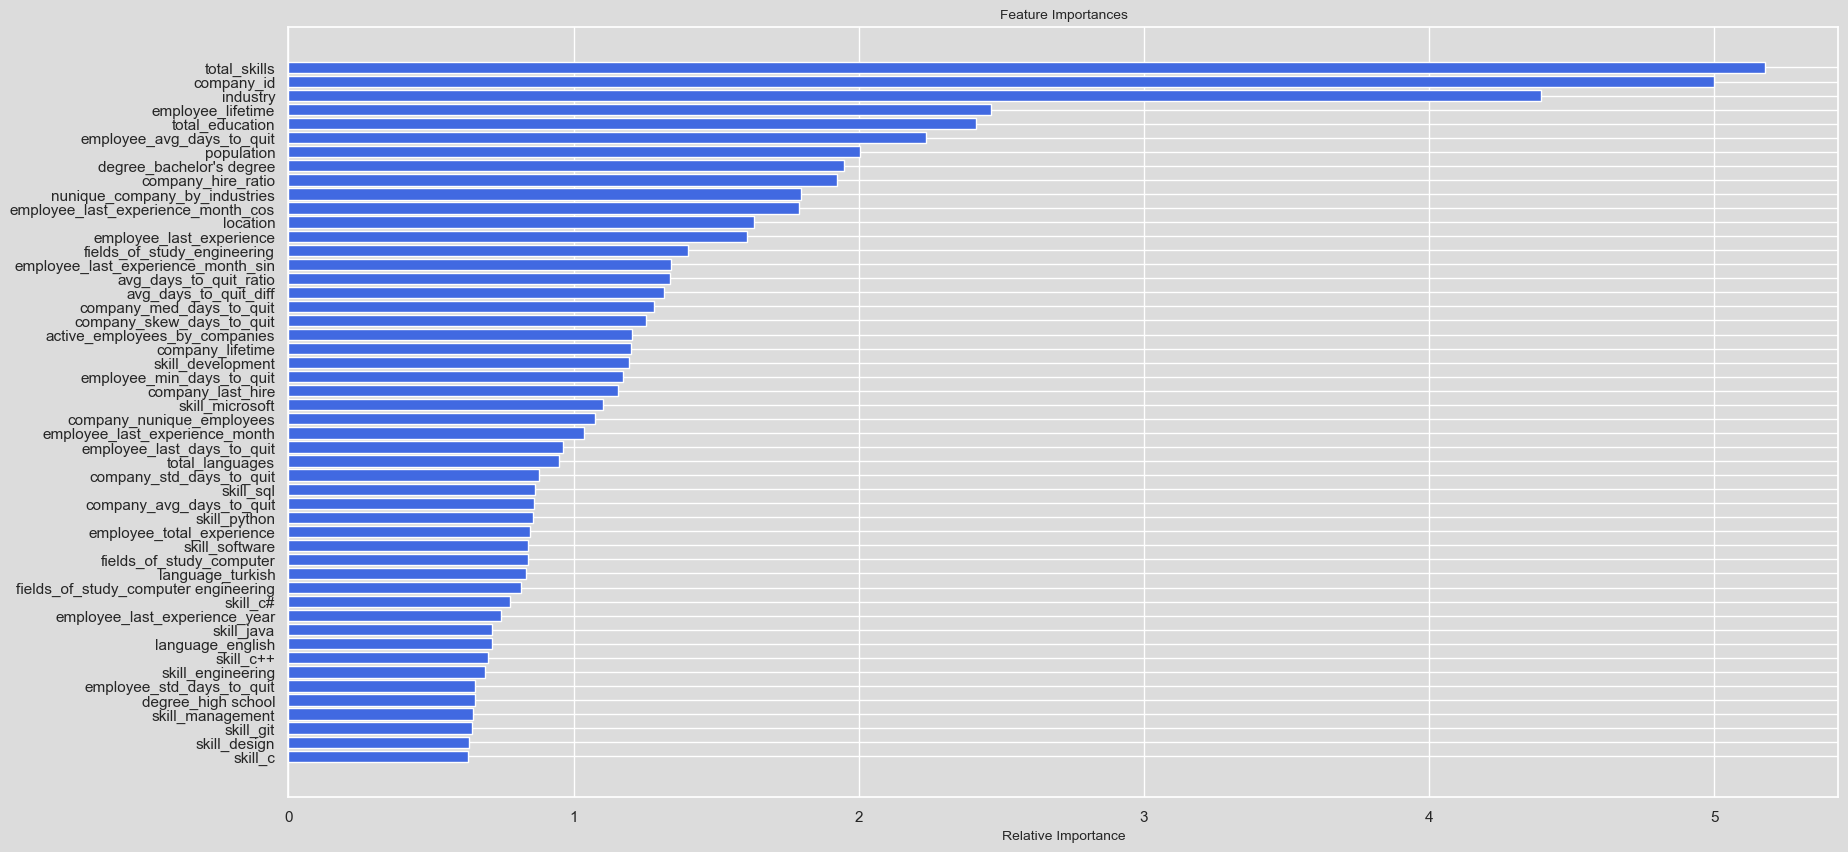

fold accuracy: 0.7938735476082692
-----------------------------------| Fold 7 |-----------------------------------
train: (46392, 289)
val: (6627, 289)
0:	learn: 0.6547896	test: 0.6395051	best: 0.6395051 (0)	total: 160ms	remaining: 13m 20s
250:	learn: 0.7752845	test: 0.7445300	best: 0.7452844 (248)	total: 34.7s	remaining: 10m 55s
500:	learn: 0.8134377	test: 0.7584126	best: 0.7587144 (495)	total: 1m 10s	remaining: 10m 29s
750:	learn: 0.8535092	test: 0.7639958	best: 0.7644485 (711)	total: 1m 45s	remaining: 9m 58s
1000:	learn: 0.8884722	test: 0.7725970	best: 0.7730496 (998)	total: 2m 22s	remaining: 9m 29s
1250:	learn: 0.9156105	test: 0.7790856	best: 0.7793874 (1231)	total: 2m 58s	remaining: 8m 54s
1500:	learn: 0.9337601	test: 0.7876867	best: 0.7878376 (1485)	total: 3m 34s	remaining: 8m 19s
1750:	learn: 0.9485472	test: 0.7896484	best: 0.7897993 (1749)	total: 4m 10s	remaining: 7m 45s
2000:	learn: 0.9591309	test: 0.7908556	best: 0.7920628 (1808)	total: 4m 46s	remaining: 7m 9s
2250:	learn: 0.

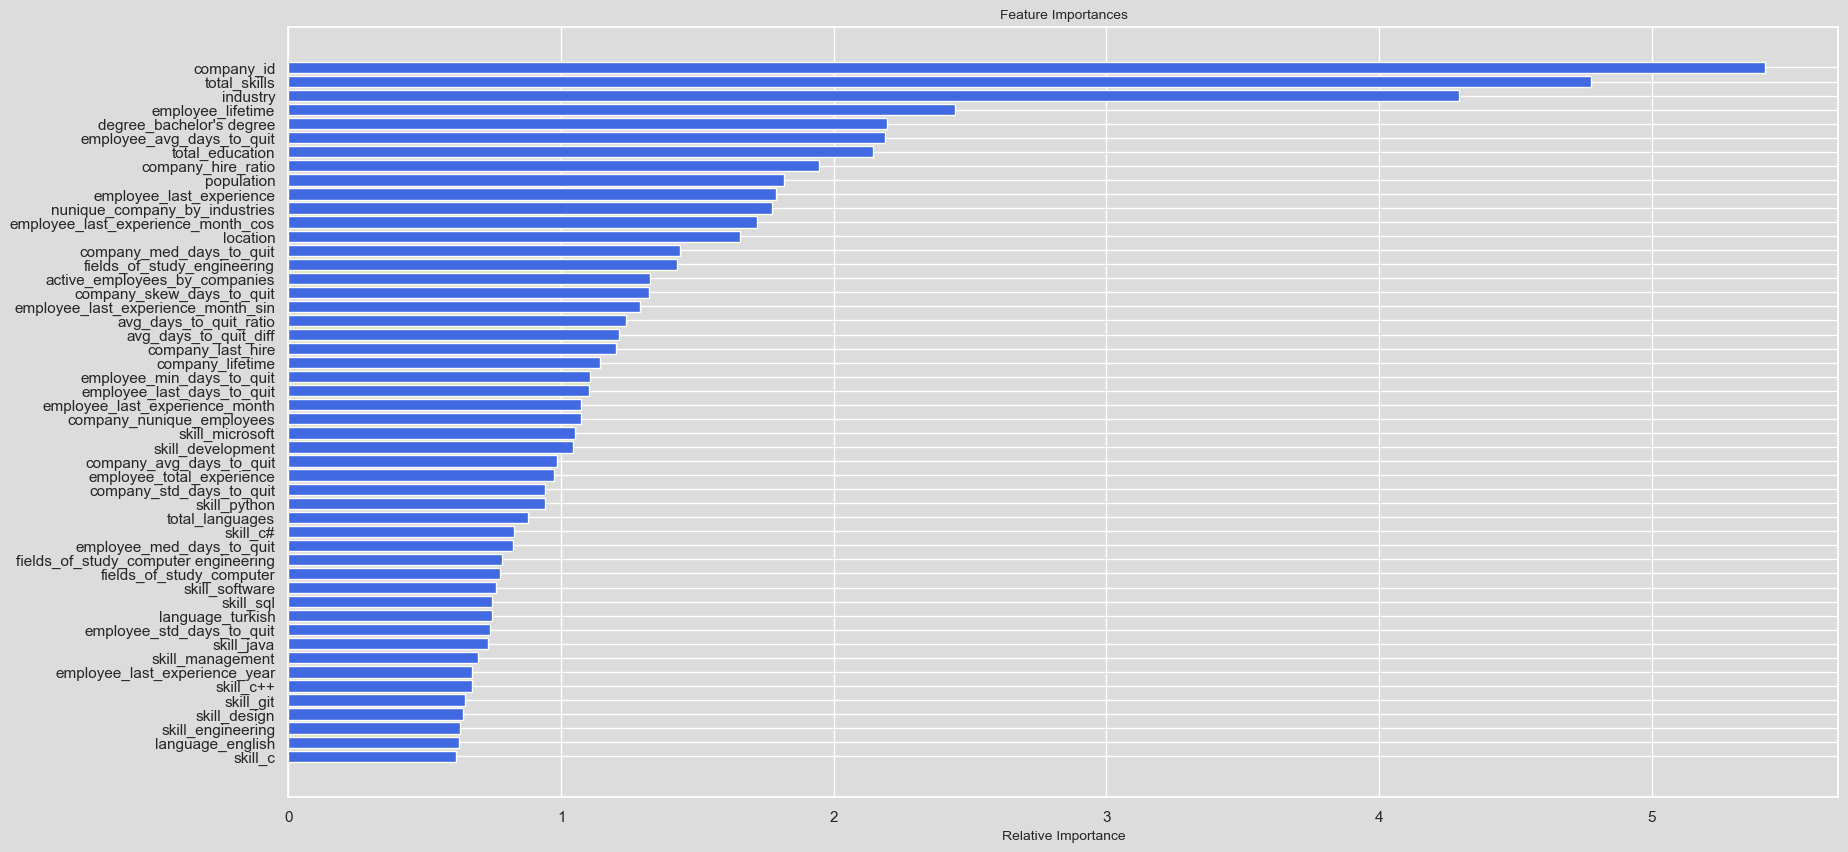

fold accuracy: 0.795080730345556
-----------------------------------| Fold 8 |-----------------------------------
train: (46392, 289)
val: (6627, 289)
0:	learn: 0.6564063	test: 0.6369398	best: 0.6369398 (0)	total: 183ms	remaining: 15m 17s
250:	learn: 0.7805656	test: 0.7406066	best: 0.7406066 (244)	total: 38s	remaining: 11m 58s
500:	learn: 0.8182445	test: 0.7528293	best: 0.7528293 (499)	total: 1m 15s	remaining: 11m 14s
750:	learn: 0.8587903	test: 0.7597706	best: 0.7603742 (731)	total: 1m 51s	remaining: 10m 33s
1000:	learn: 0.8951112	test: 0.7676173	best: 0.7685227 (990)	total: 2m 32s	remaining: 10m 8s
1250:	learn: 0.9196629	test: 0.7721443	best: 0.7730496 (1222)	total: 3m 9s	remaining: 9m 26s
1500:	learn: 0.9384377	test: 0.7769730	best: 0.7774257 (1465)	total: 3m 46s	remaining: 8m 48s
1750:	learn: 0.9517158	test: 0.7774257	best: 0.7781802 (1731)	total: 4m 22s	remaining: 8m 7s
2000:	learn: 0.9617391	test: 0.7802927	best: 0.7810472 (1948)	total: 4m 58s	remaining: 7m 28s
2250:	learn: 0.970

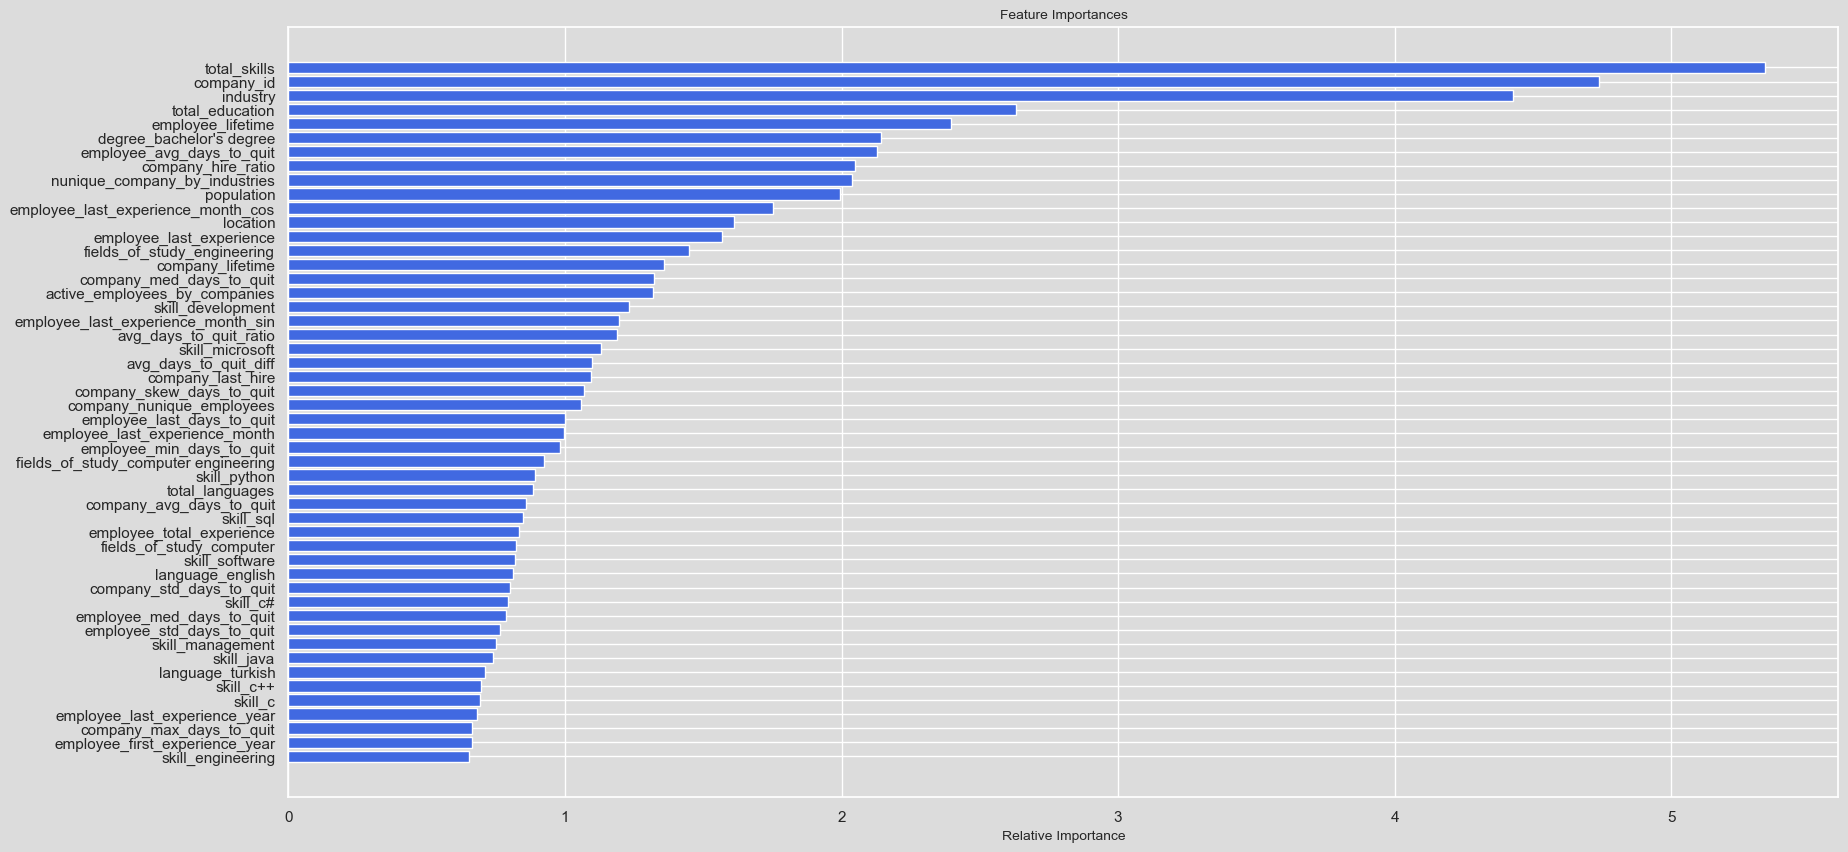

fold accuracy: 0.7860268598159046
accuracy: 0.7915841490786322
folds avg accuracy: 0.7915841202195915
folds std accuracy: 0.0029373729238646486


In [9]:
cat1_scores, cat1_train_scores = get_model_scores(cat1, skf, train_set, test_set, 'moved_after_2019', config.n_folds, True)

In [10]:
thr = 0.499
score_ = list()
w_range = np.arange(0.02, 0.98, 0.02)
for i in w_range:
    score_.append(
        accuracy_score(
            train_set[target],
            np.where(
                cat1_train_scores[:, 1] * i + xgb1_train_scores[:, 1] * (1 - i)
                >= thr,
                1,
                0,
            ),
        )
    )

max_score = np.max(score_)
print(f"max score: {max_score}")
w1 = round(w_range[np.argmax(score_)], 2)
w2 = round(1-w1, 2)
print(f"weights with highest accuracy: {w1} - {w2}")

max score: 0.7941869895697768
weights with highest accuracy: 0.54 - 0.46


In [11]:
sub[target] = np.where((cat1_scores[:, 1] * w1) + (xgb1_scores[:, 1] * w2)  >= thr, 1, 0)

print(sub[target].value_counts())

sub.head(10)

0    9056
1    4199
Name: moved_after_2019, dtype: int64


,user_id,moved_after_2019
0,17449,0
1,33967,1
2,2110,0
3,55082,0
4,37165,0
5,42841,1
6,8407,0
7,17053,0
8,24437,1
9,44394,0


In [12]:
sub.to_csv(f'../submissions/ensemble_cat_xgb_{round(max_score, 6)}.csv', index = False)